Fixed colorbar range: vmin=1, vmax=84.0


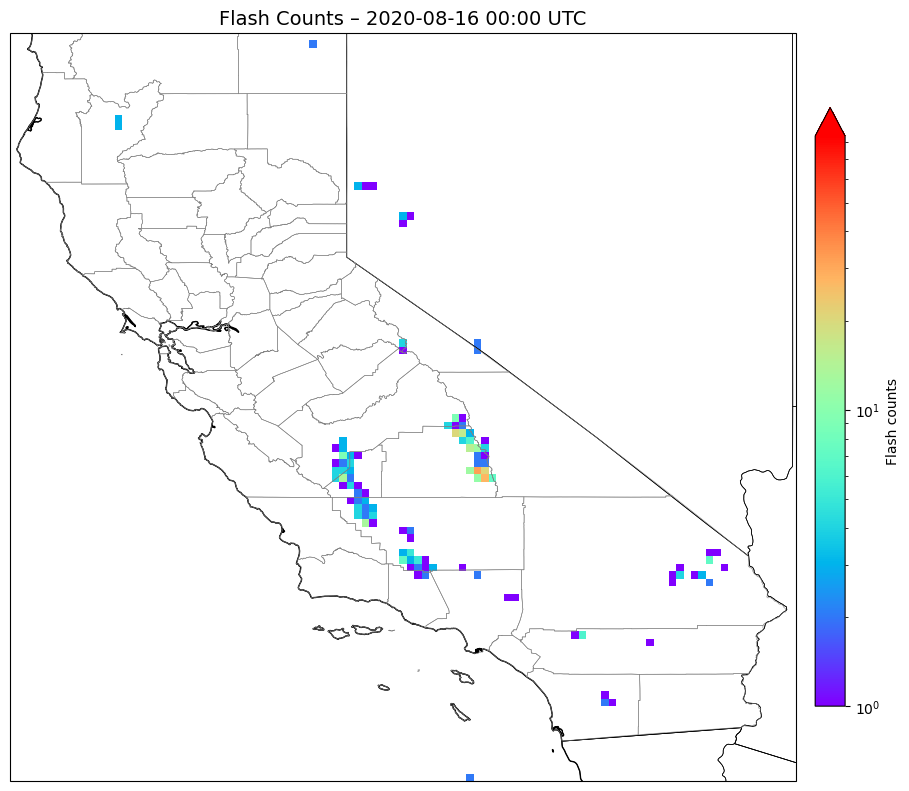

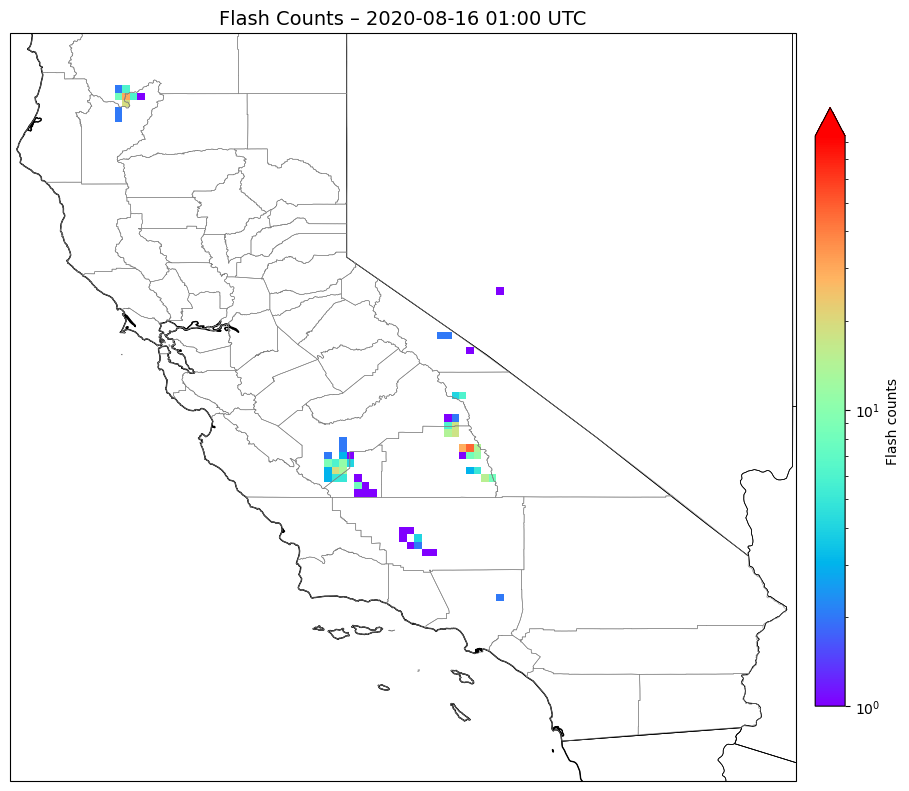

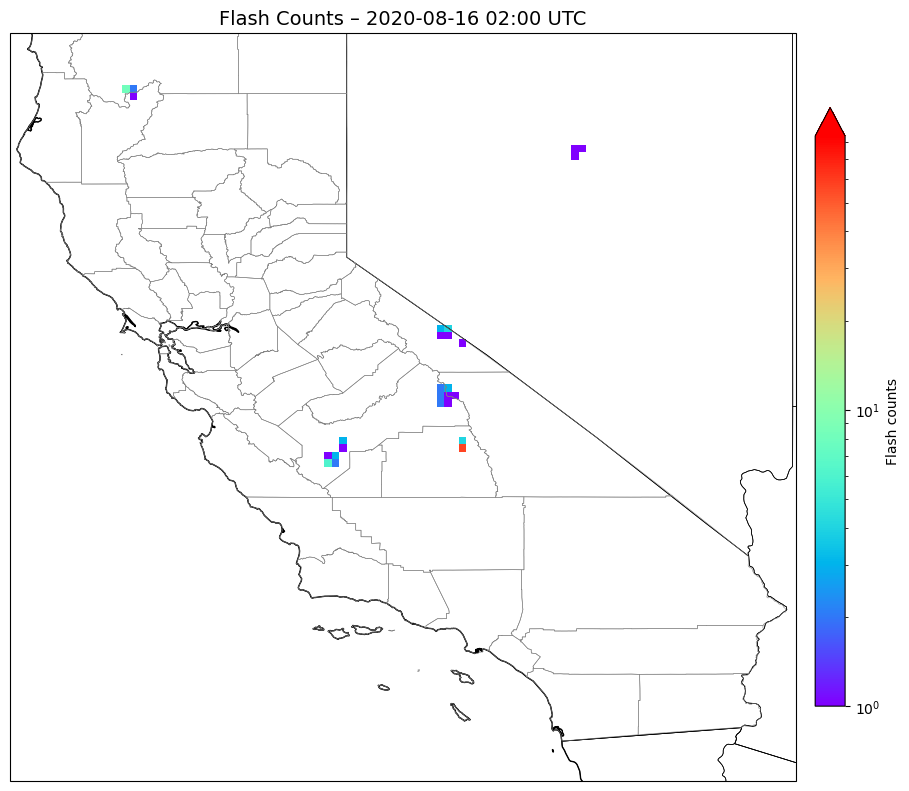

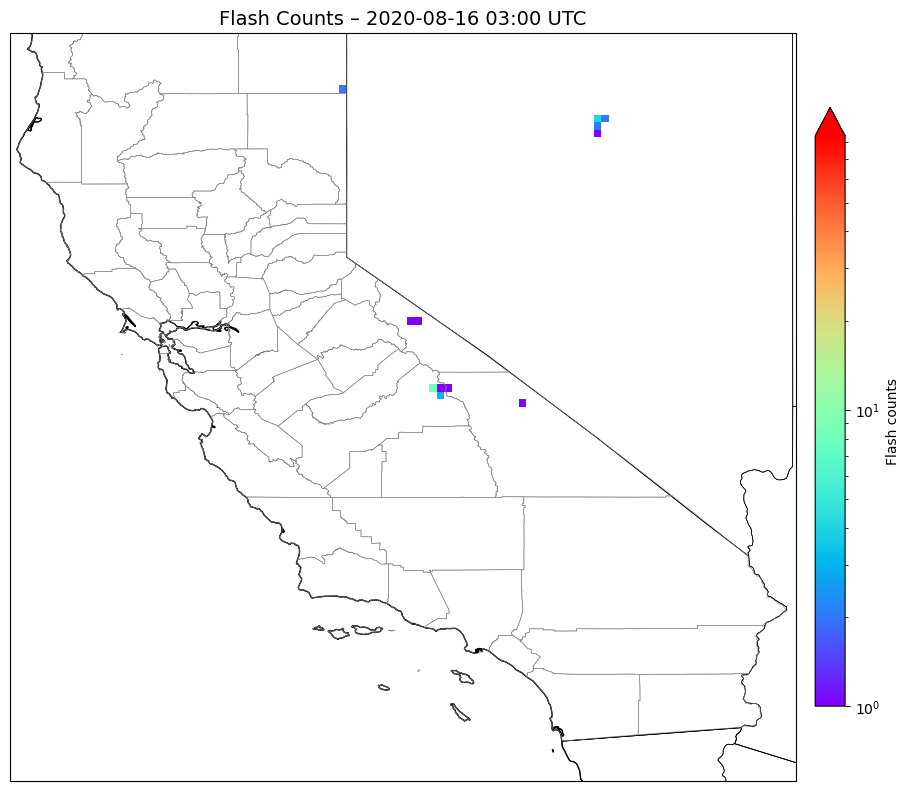

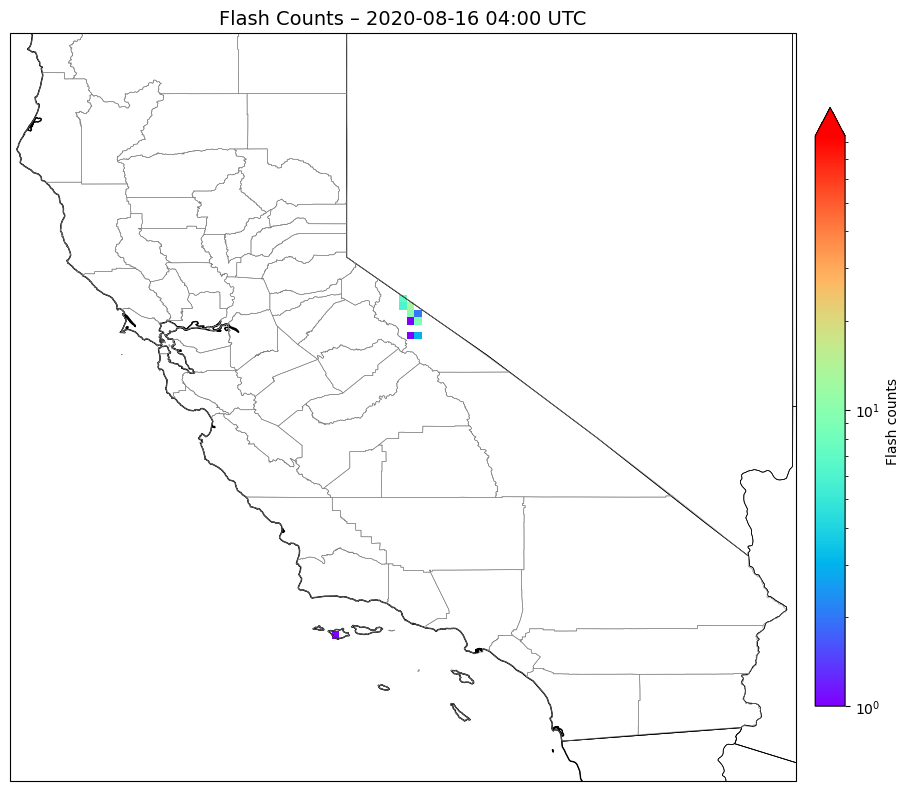

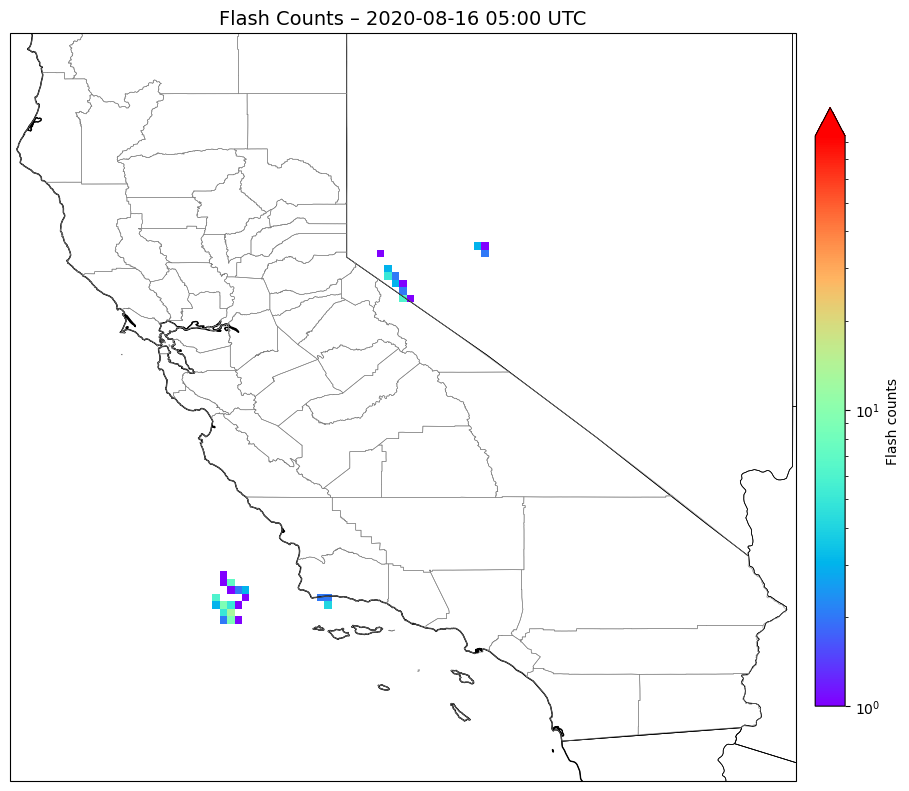

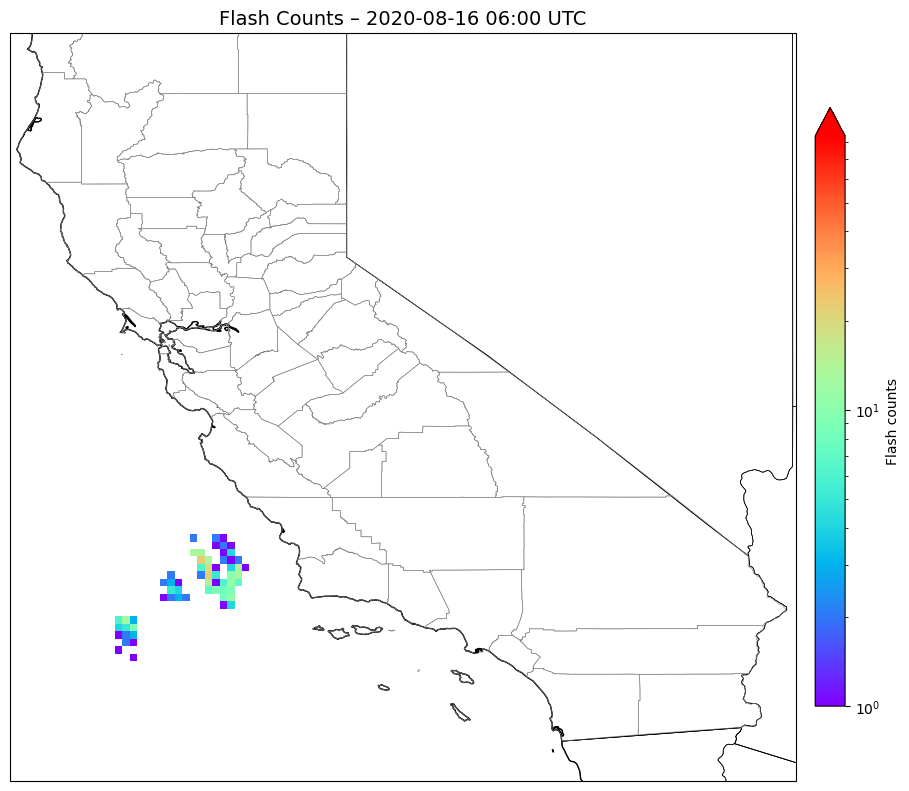

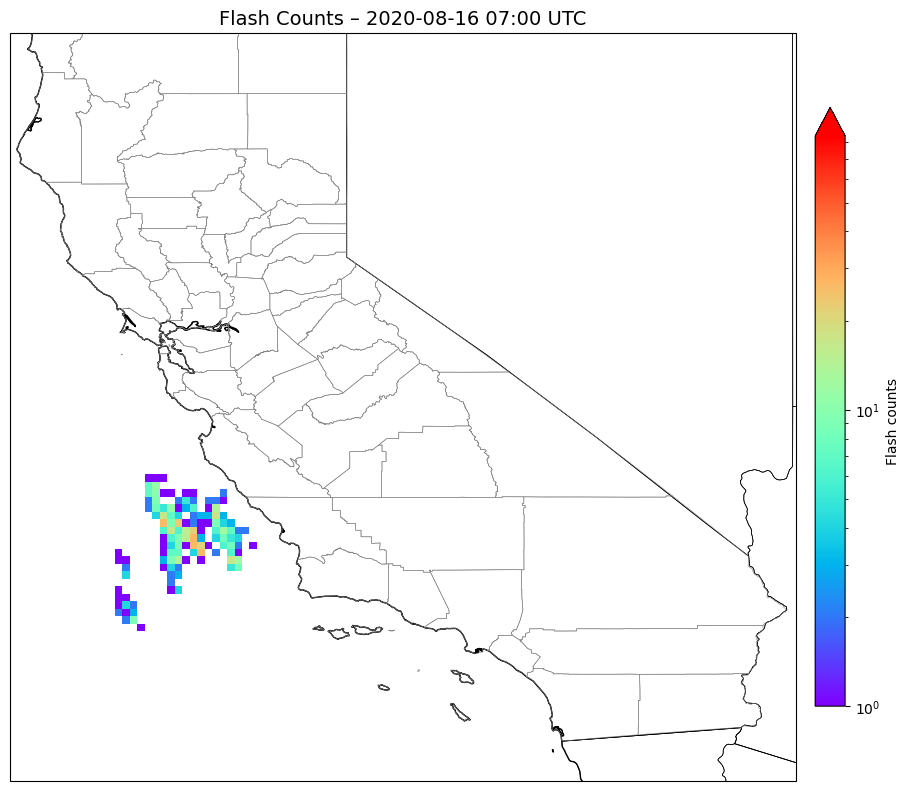

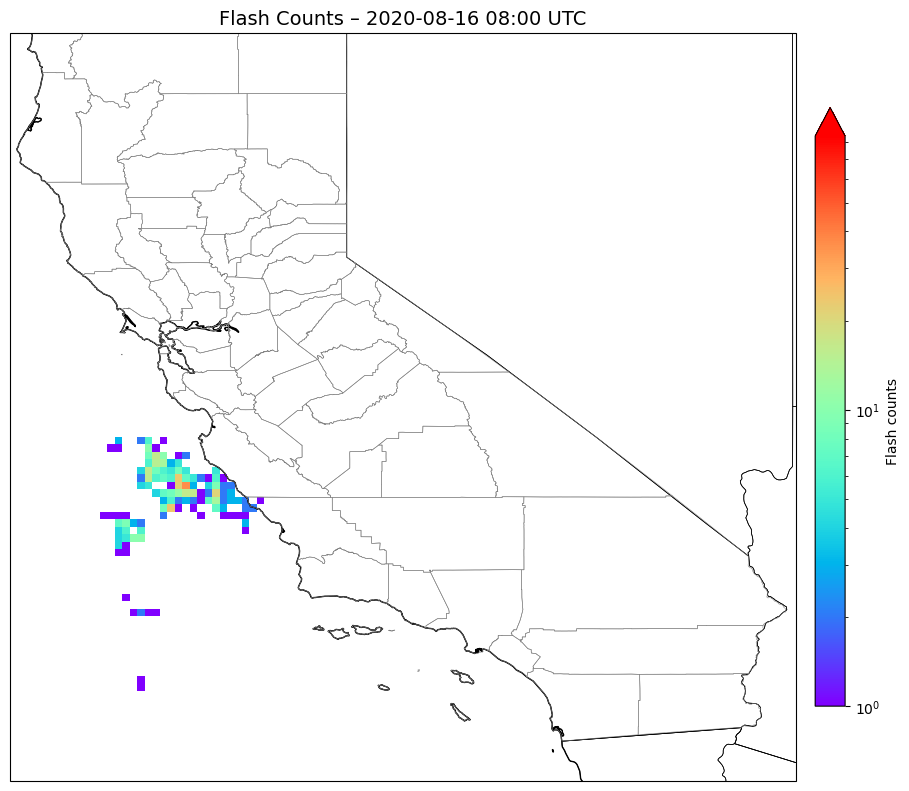

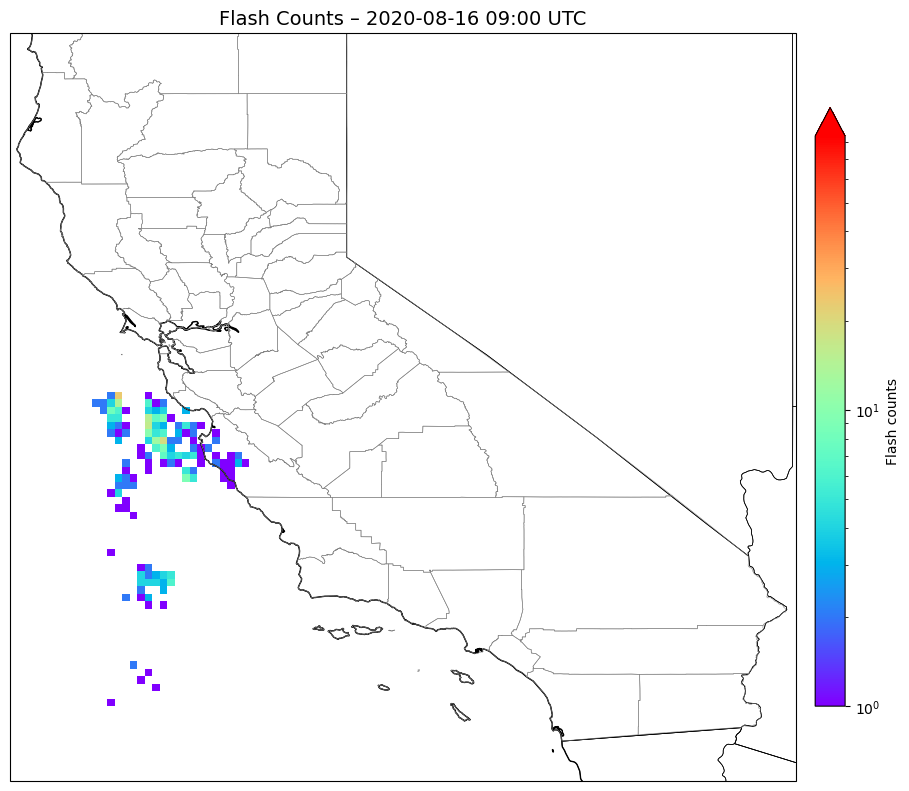

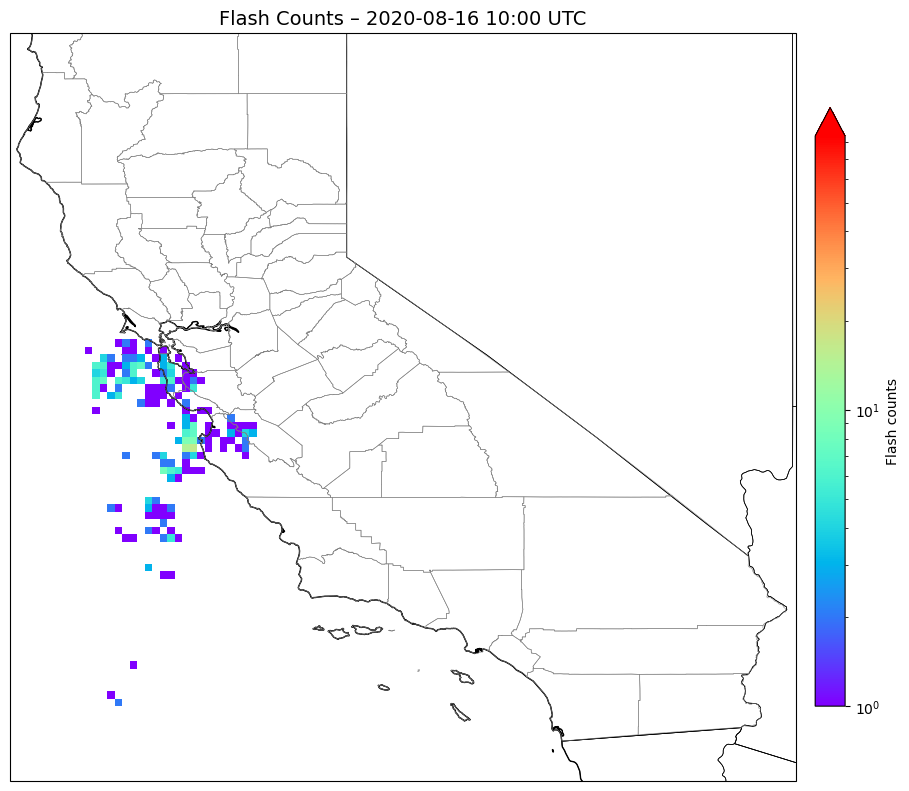

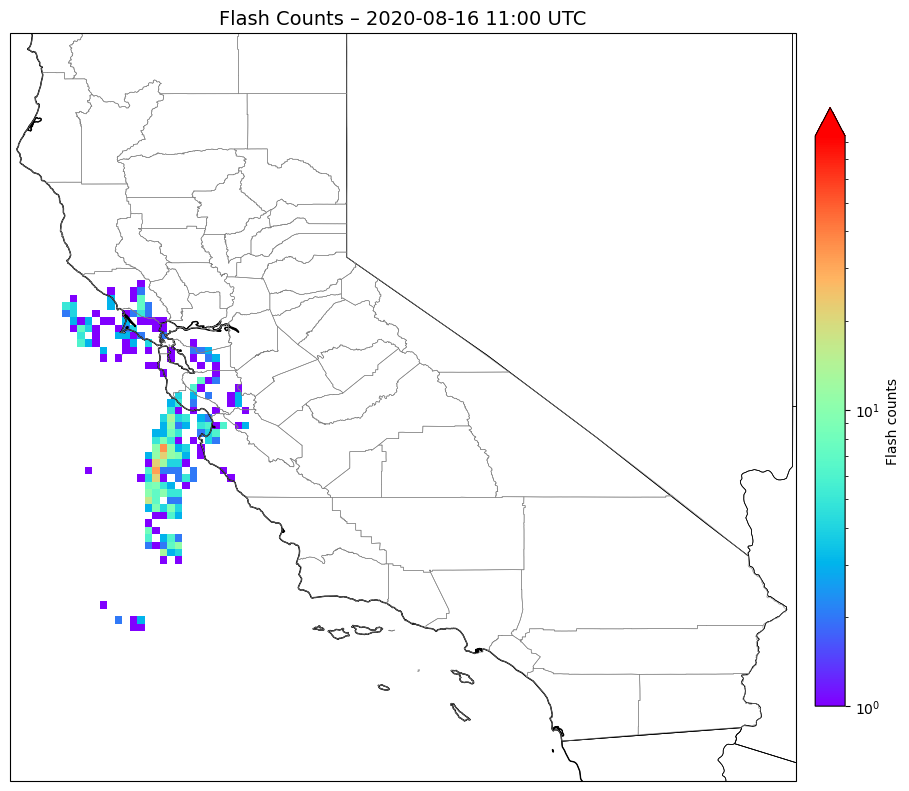

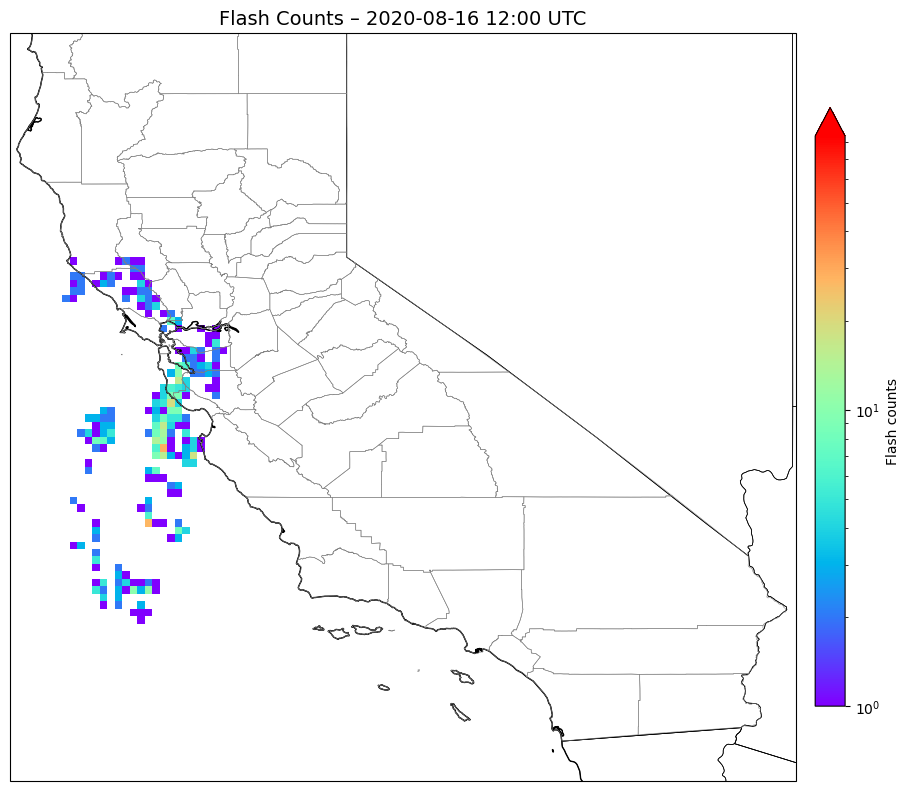

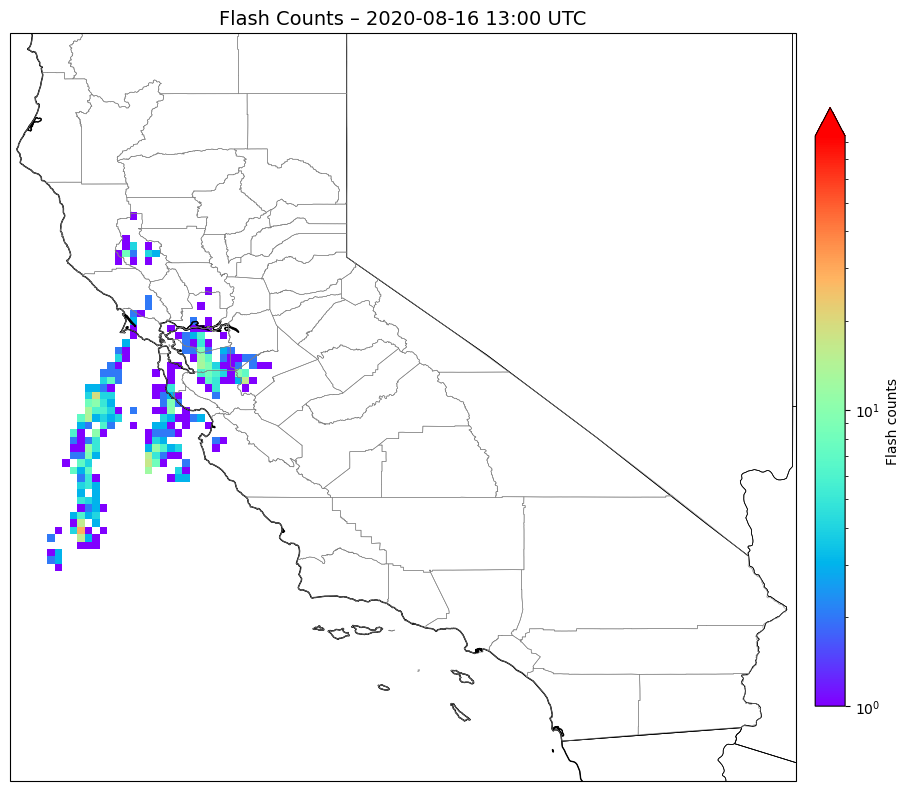

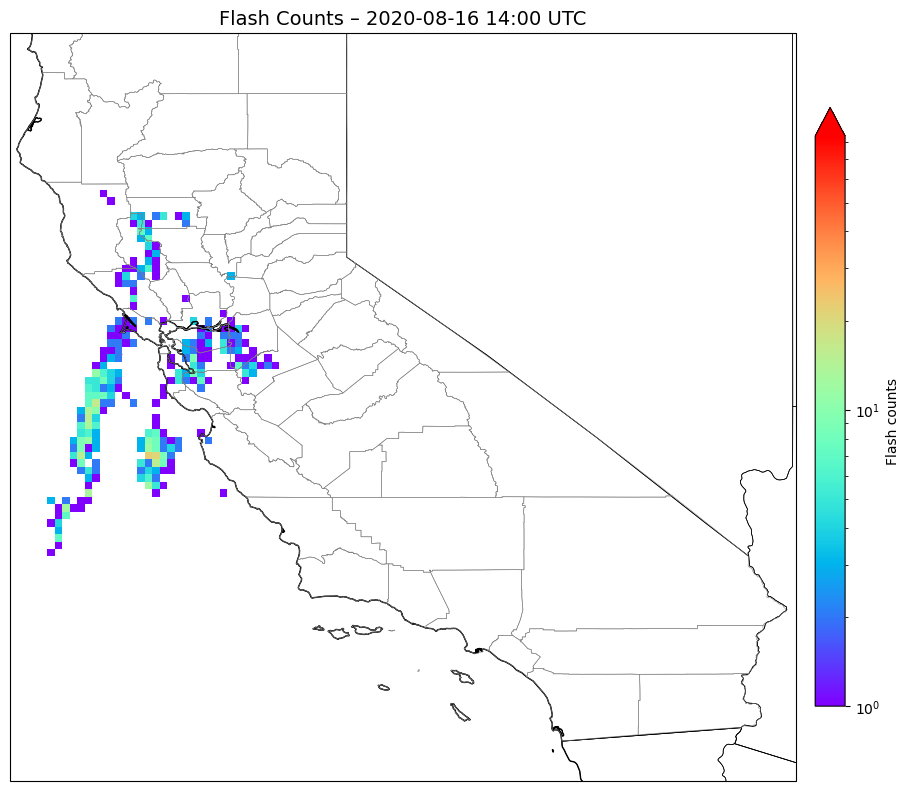

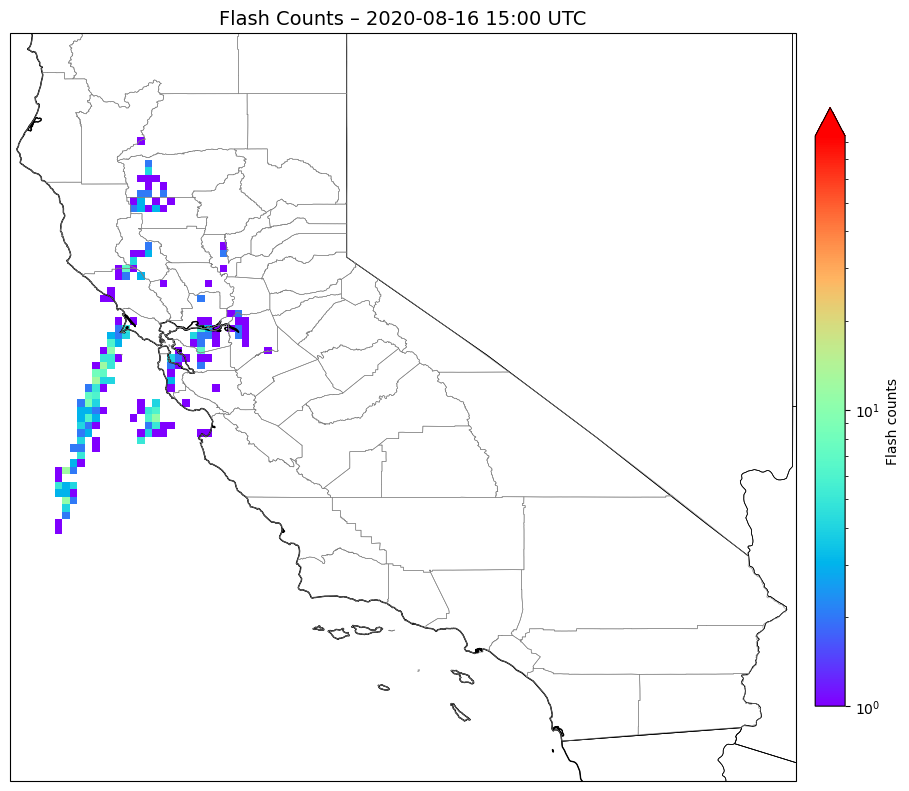

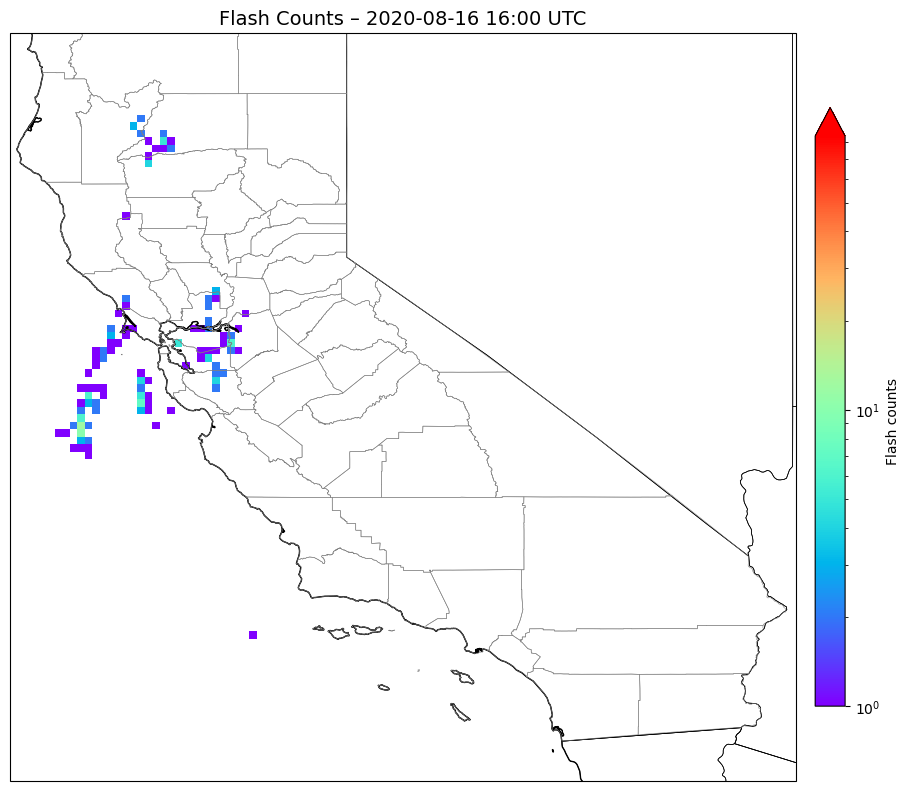

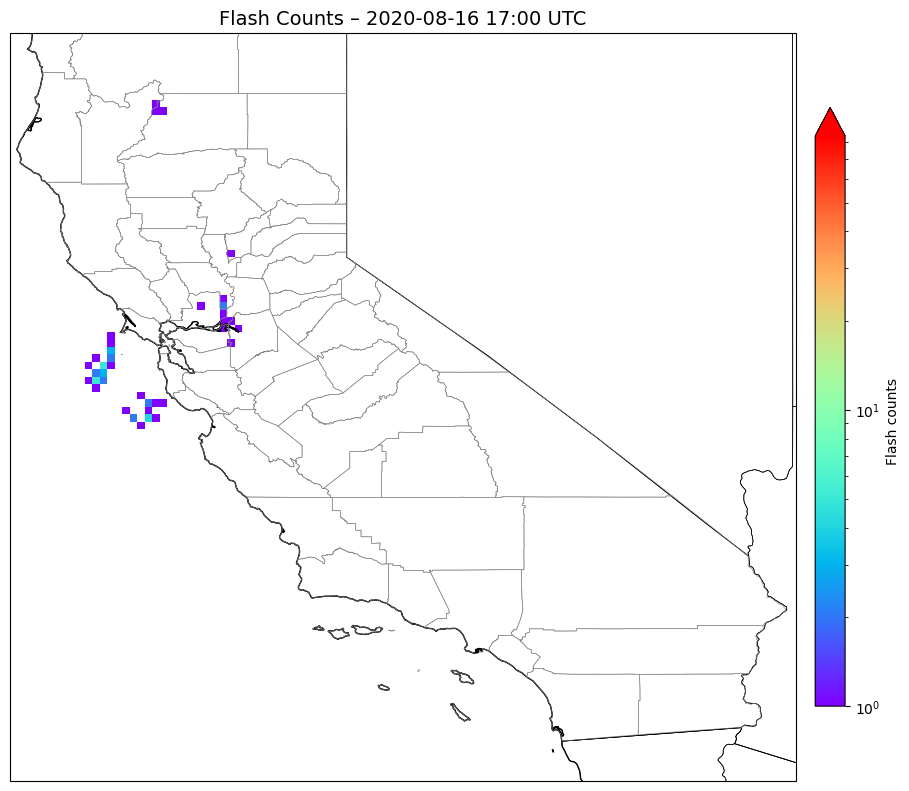

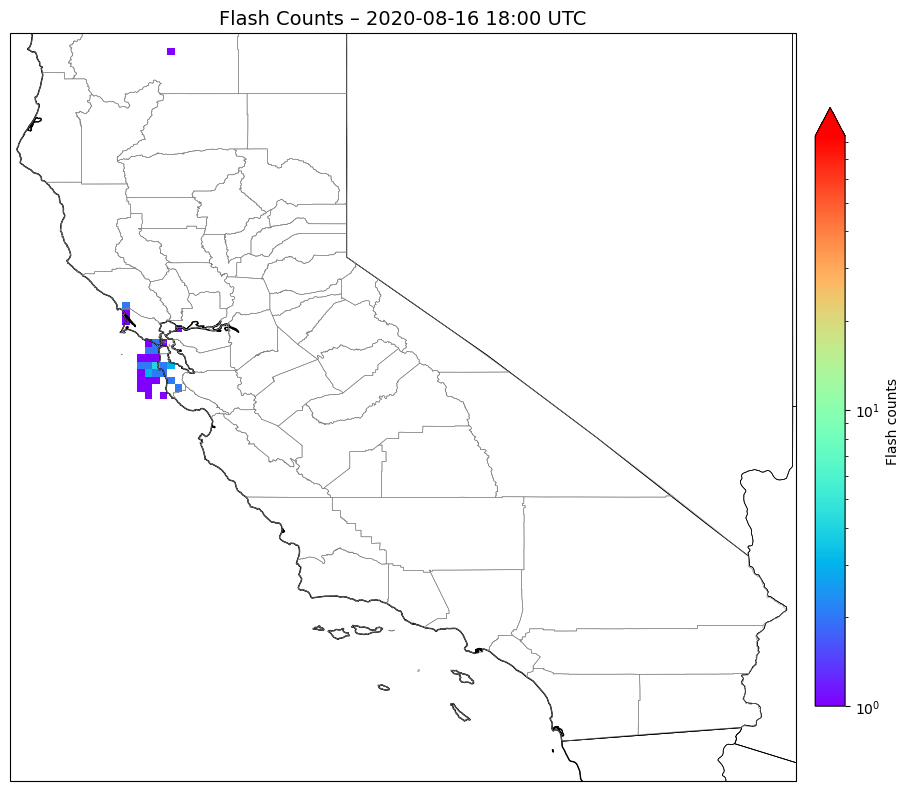

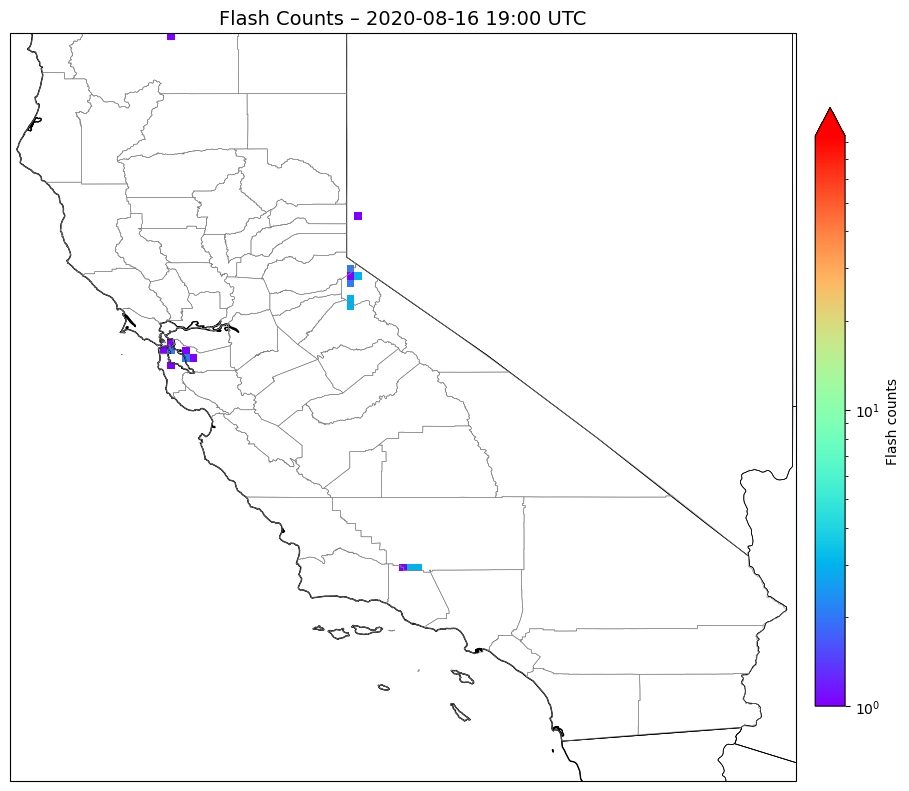

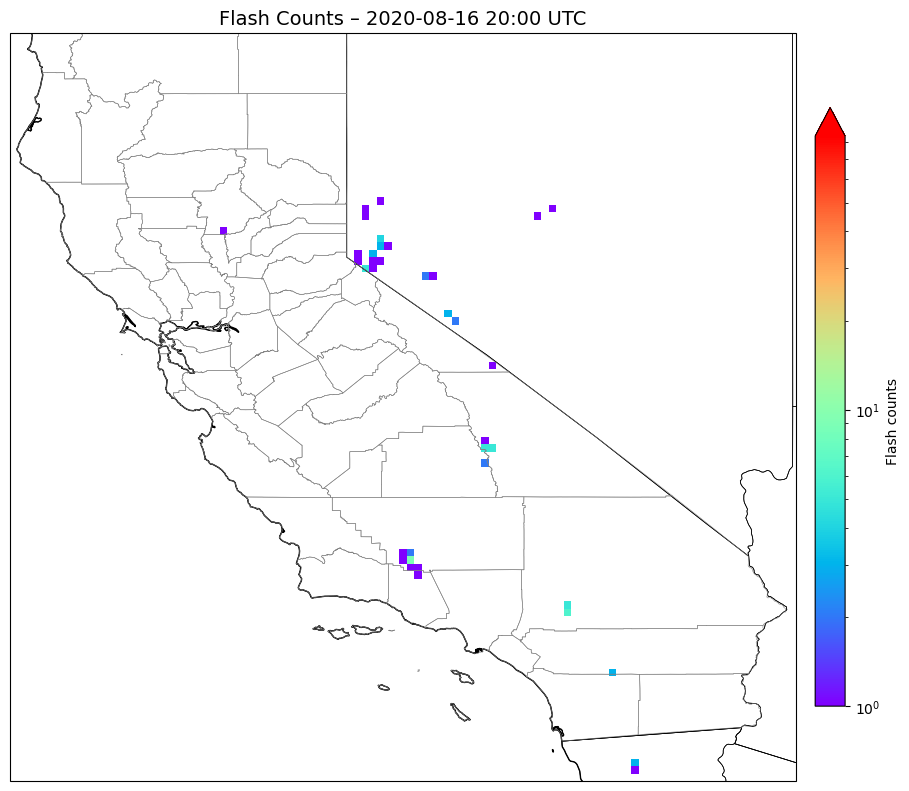

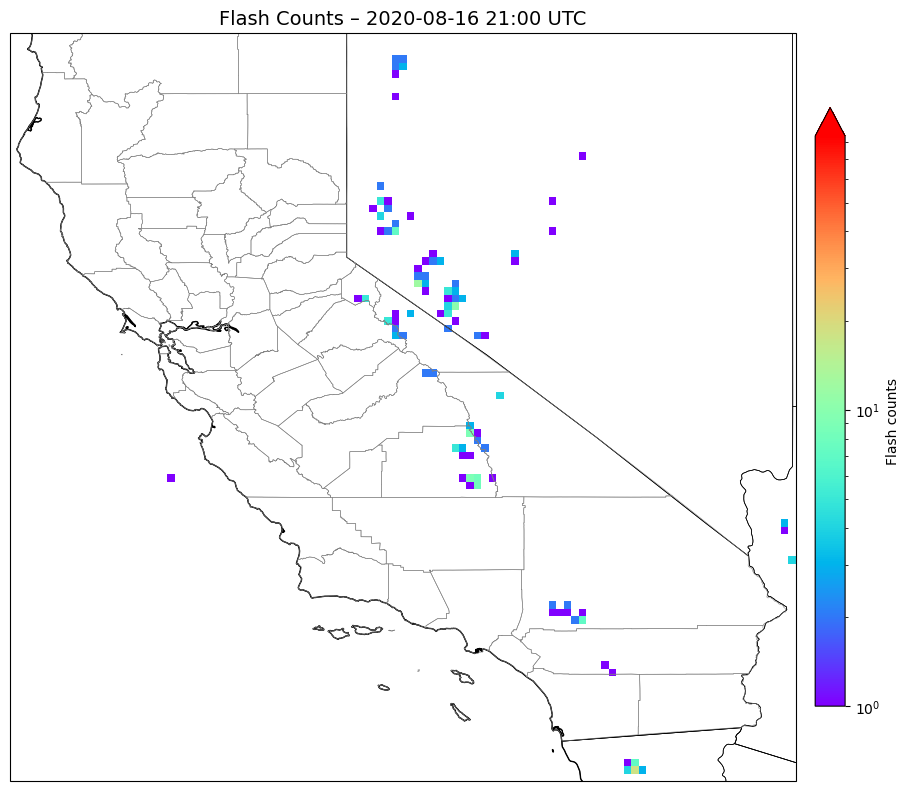

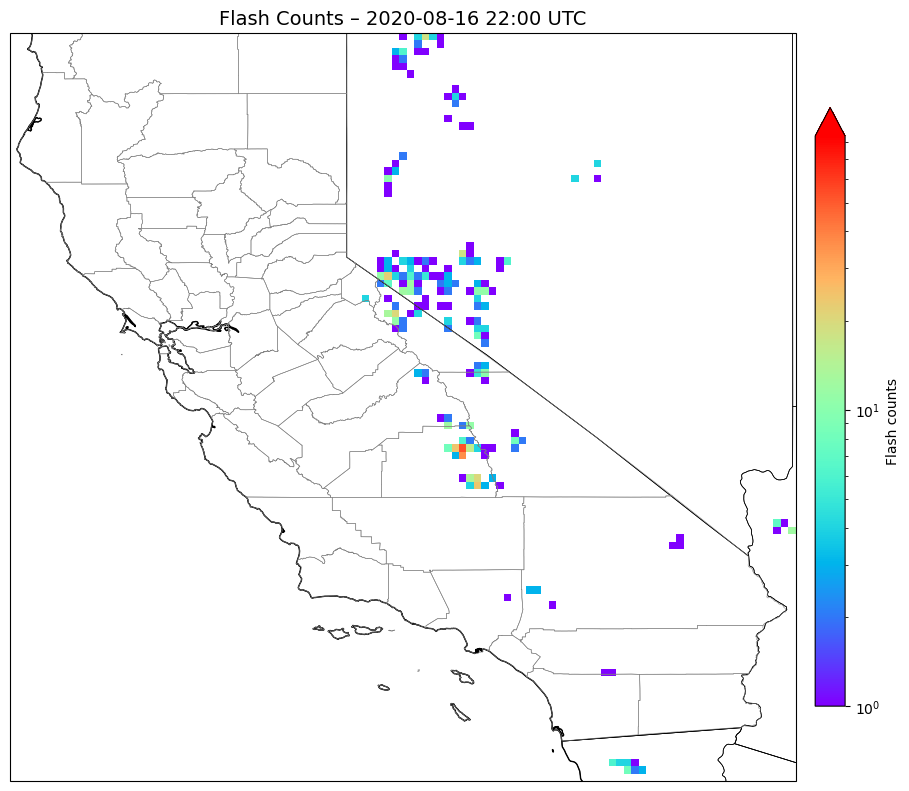

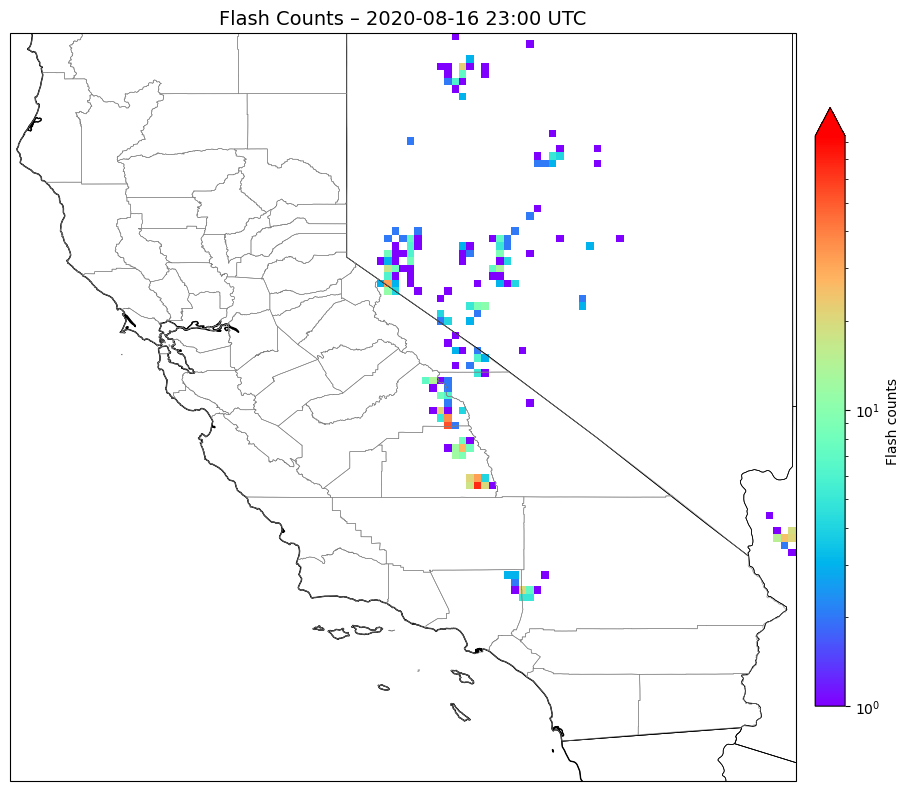

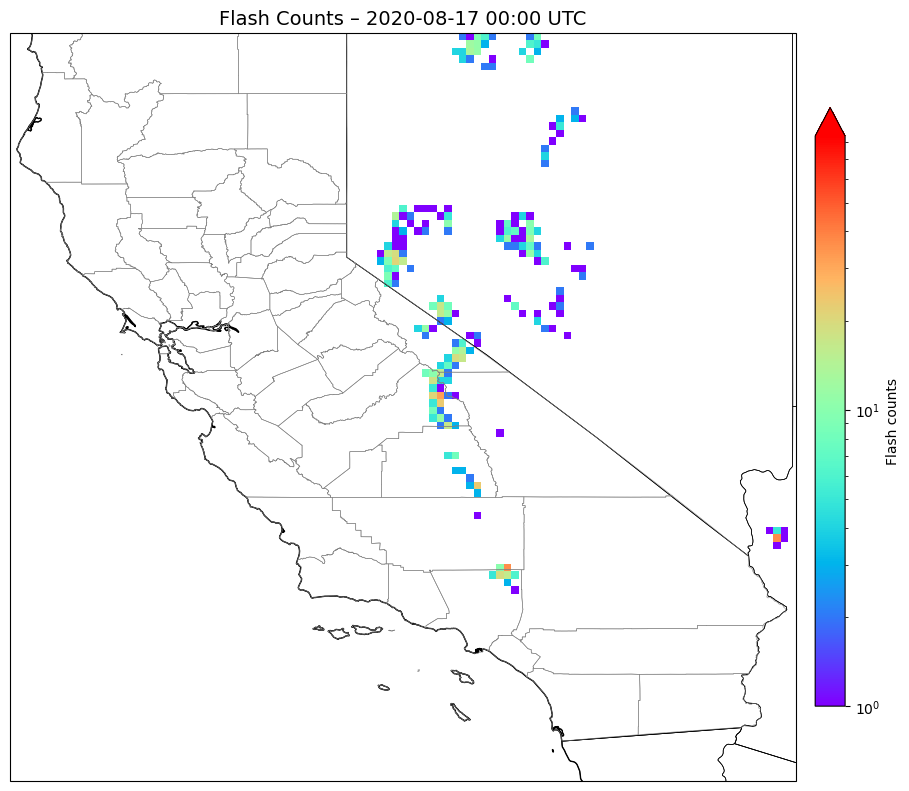

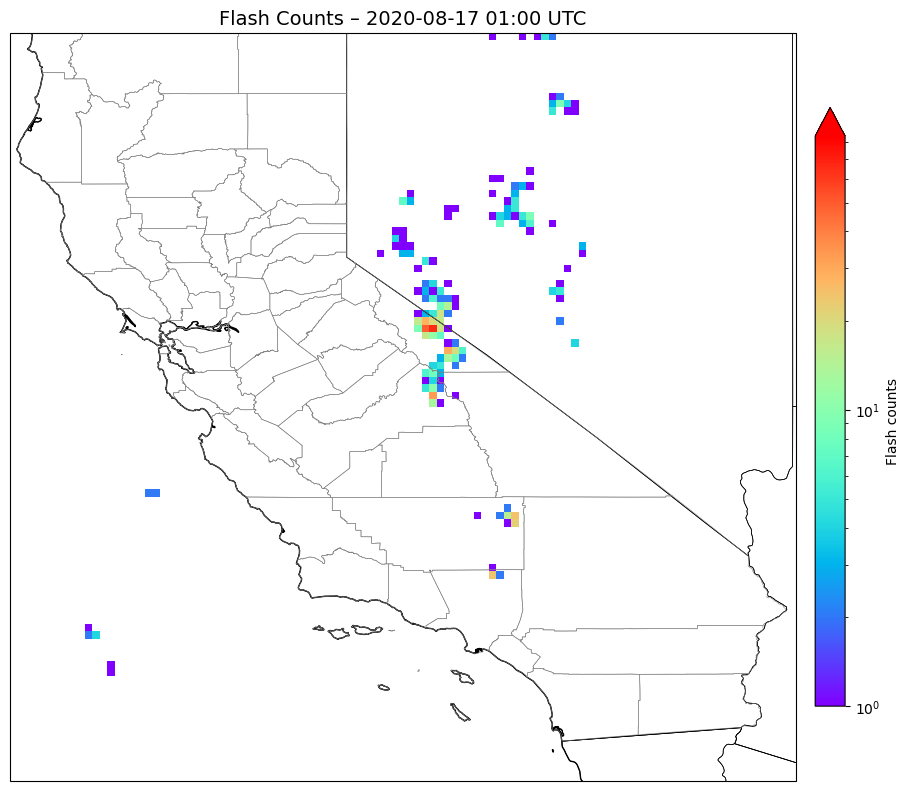

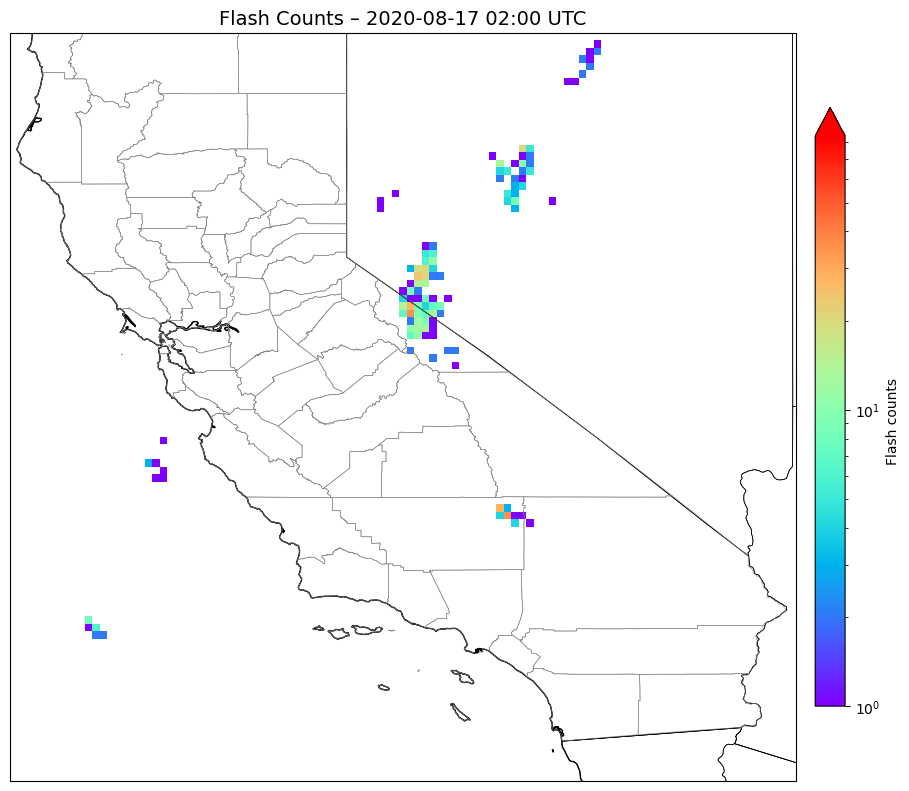

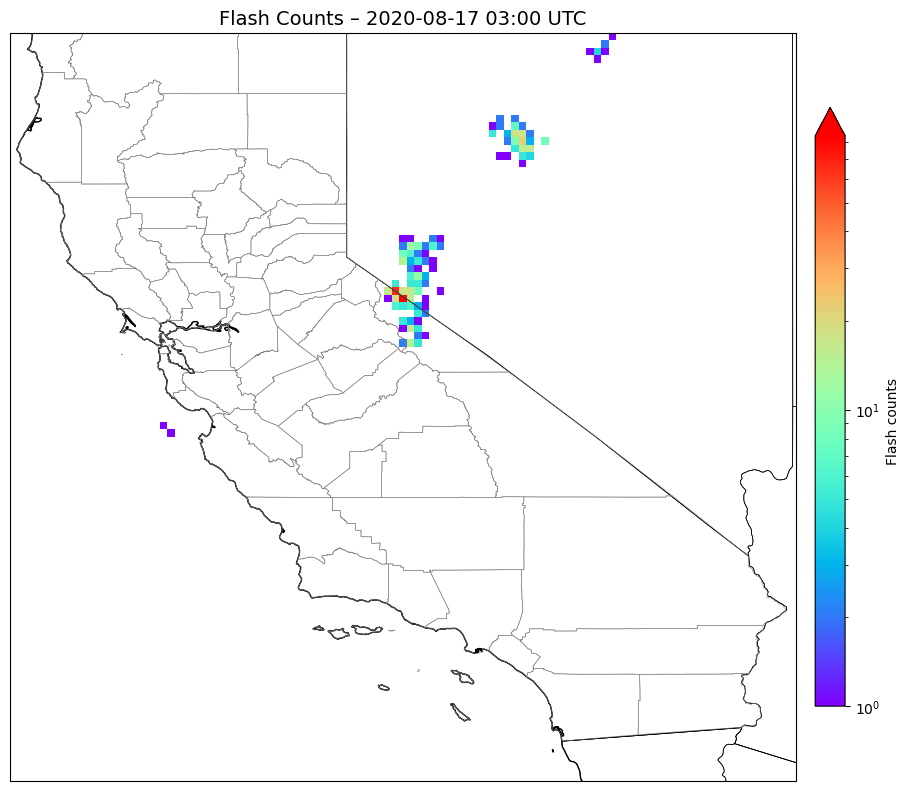

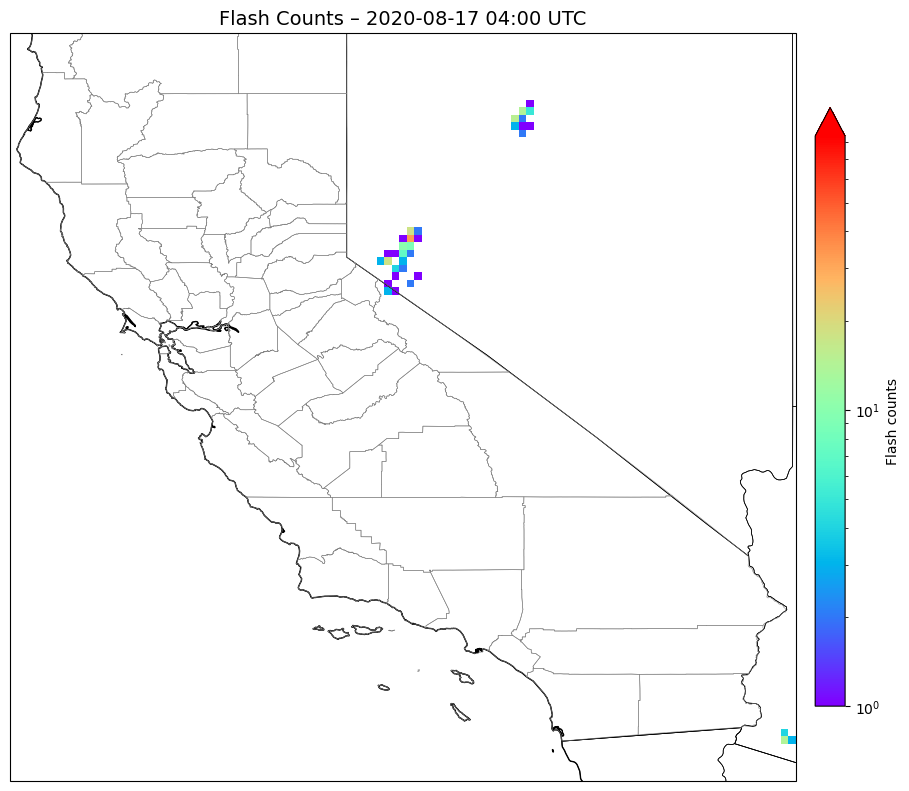

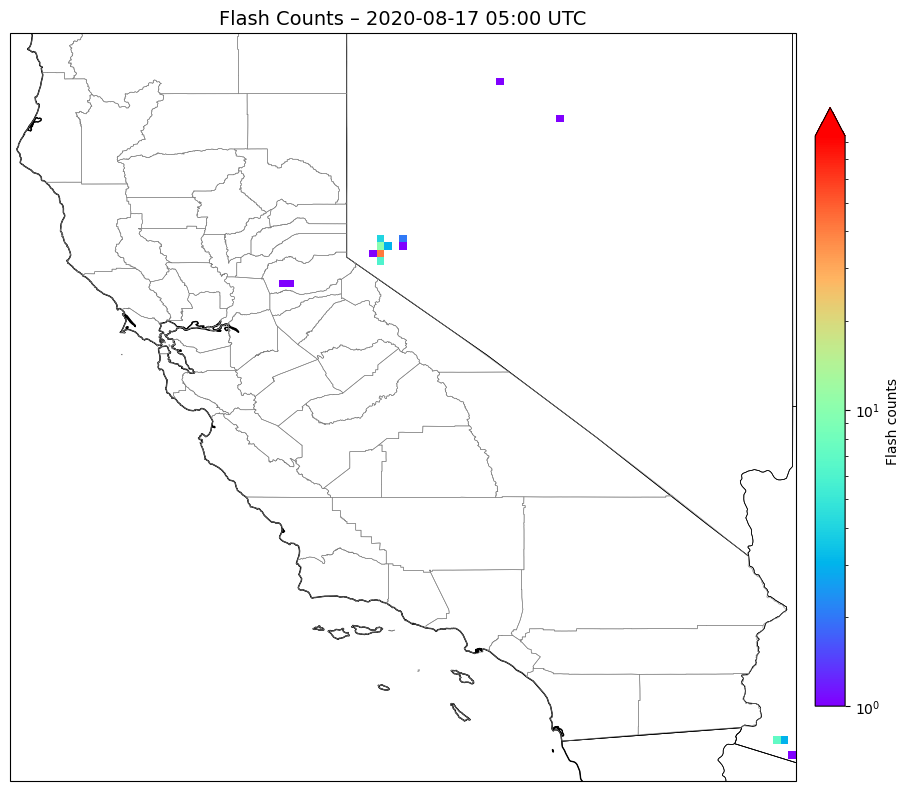

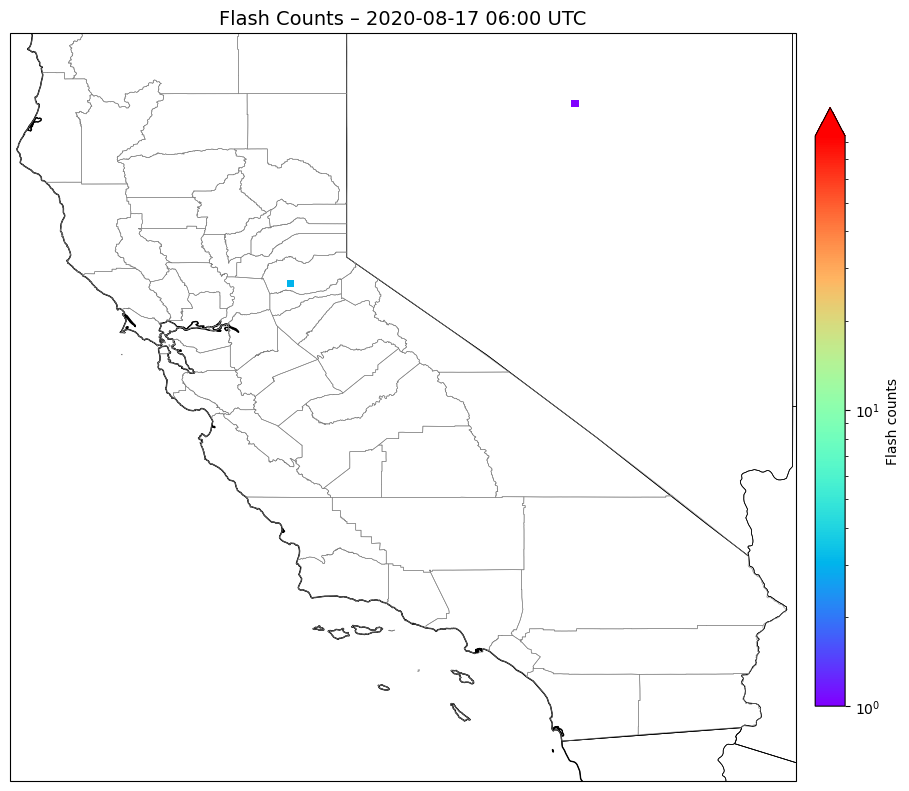

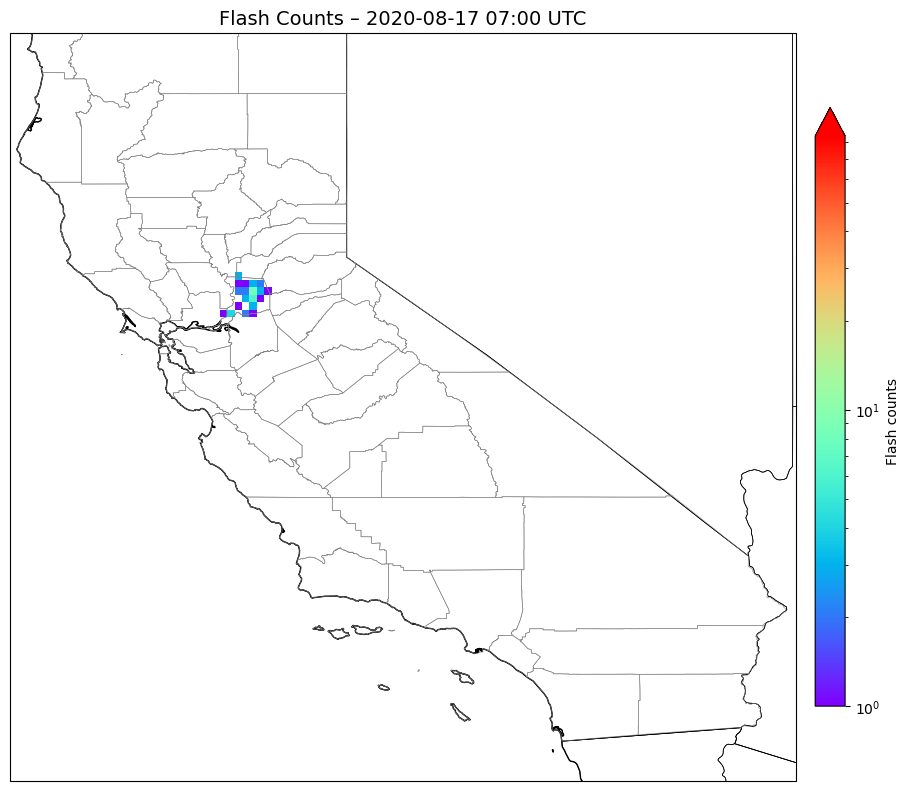

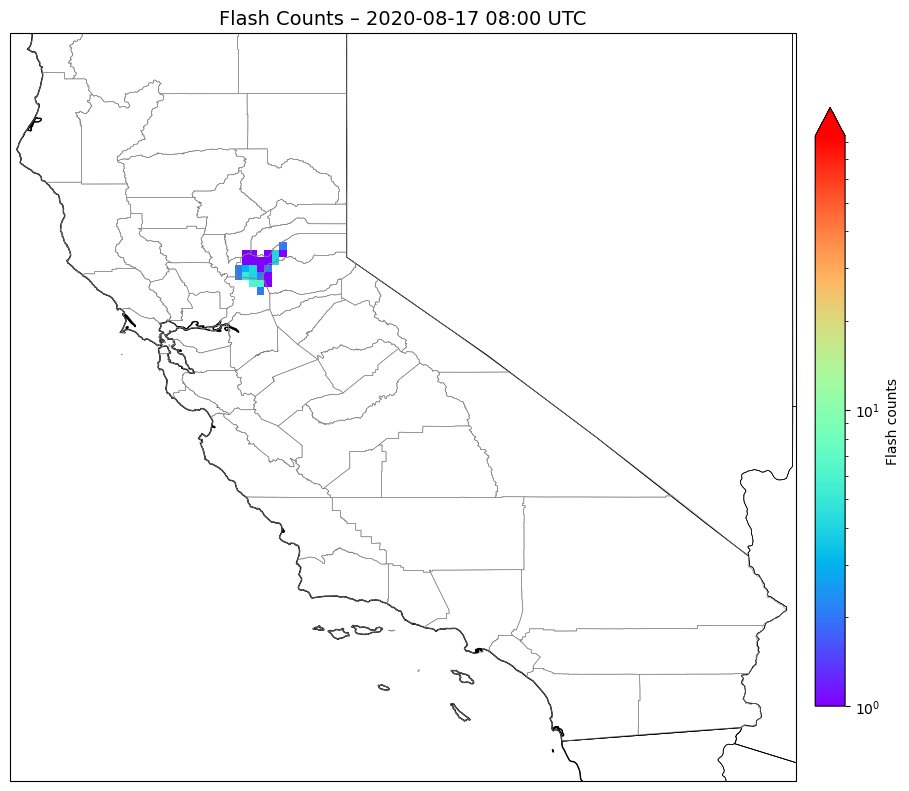

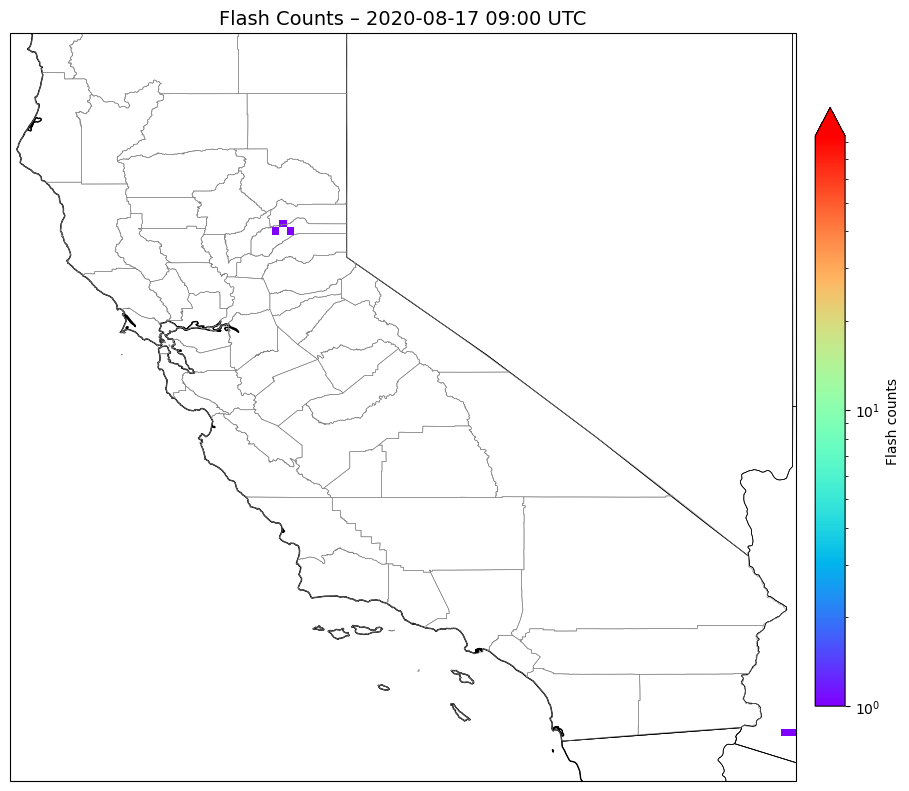

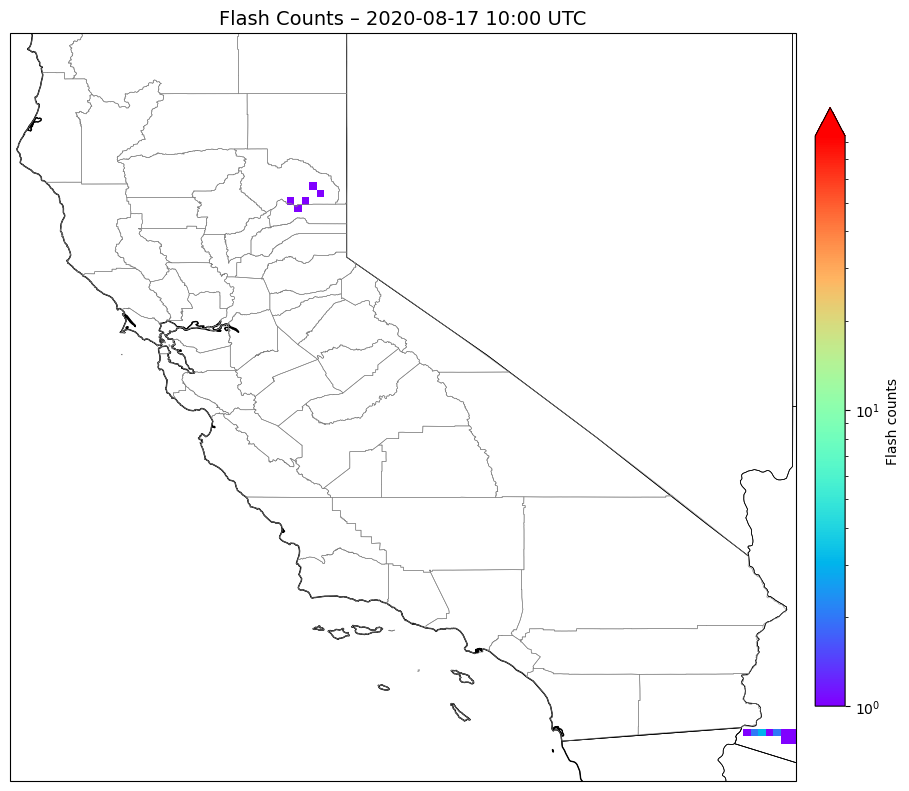

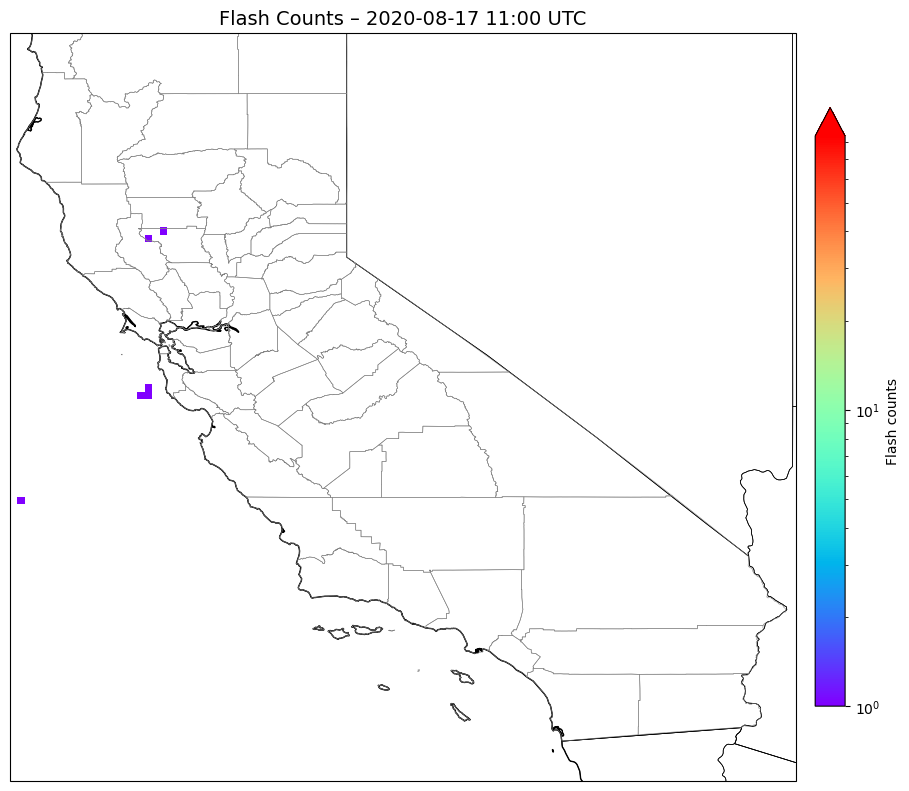

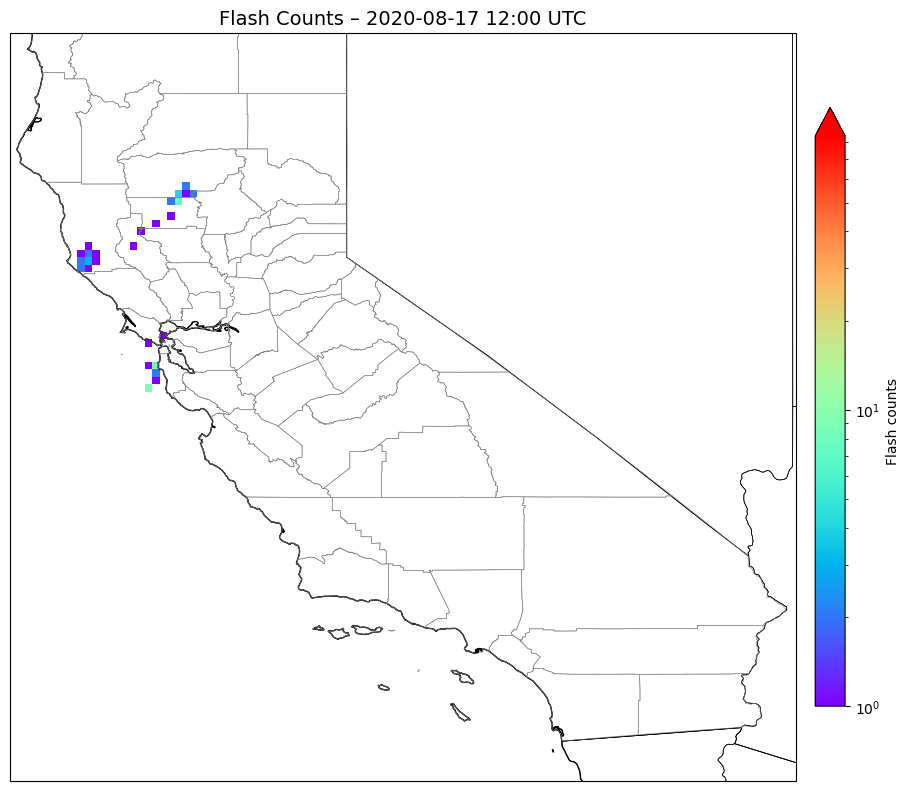

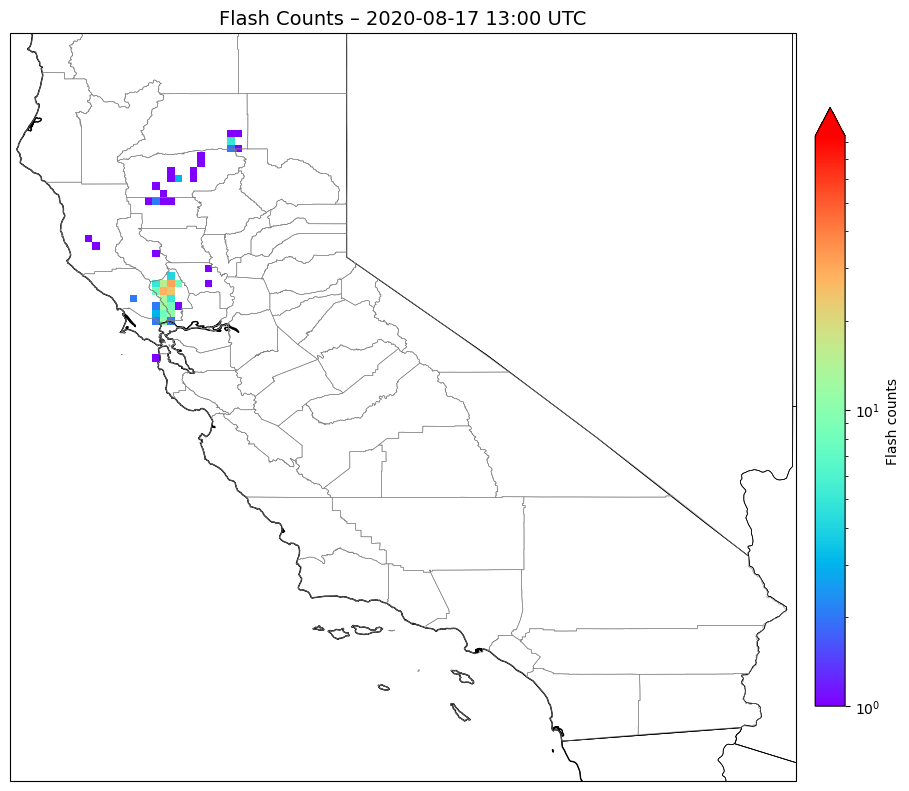

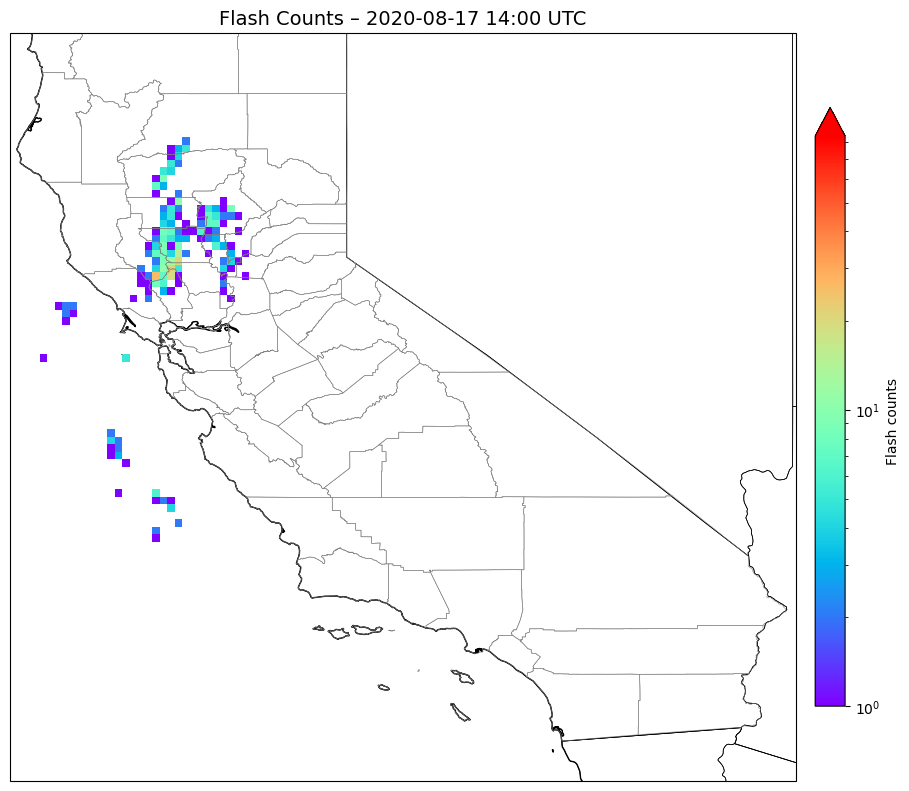

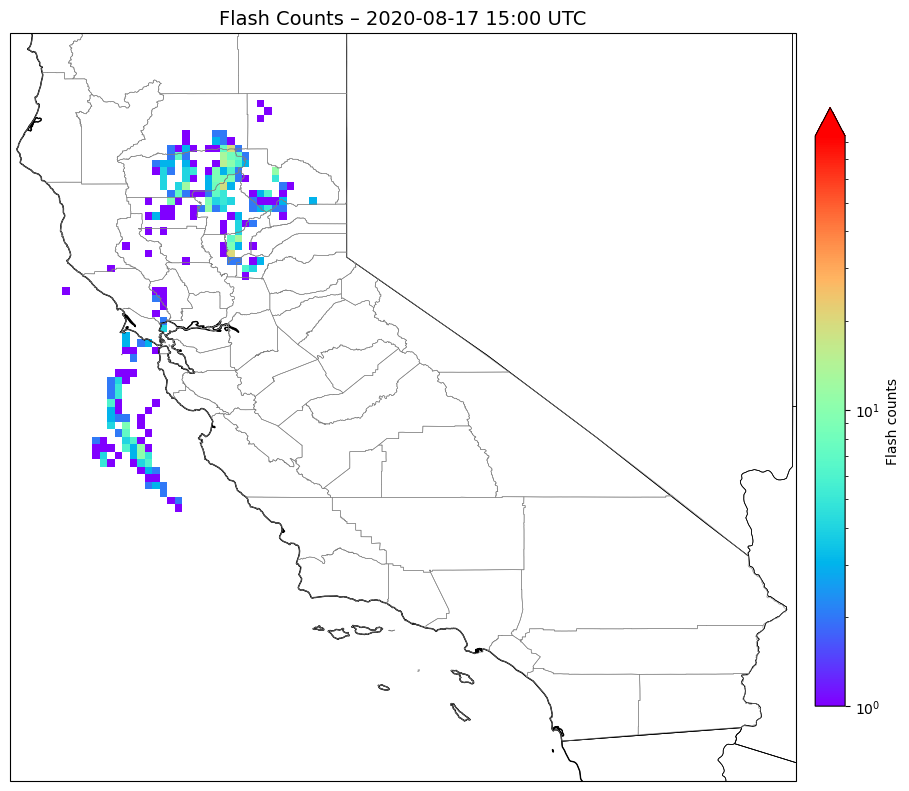

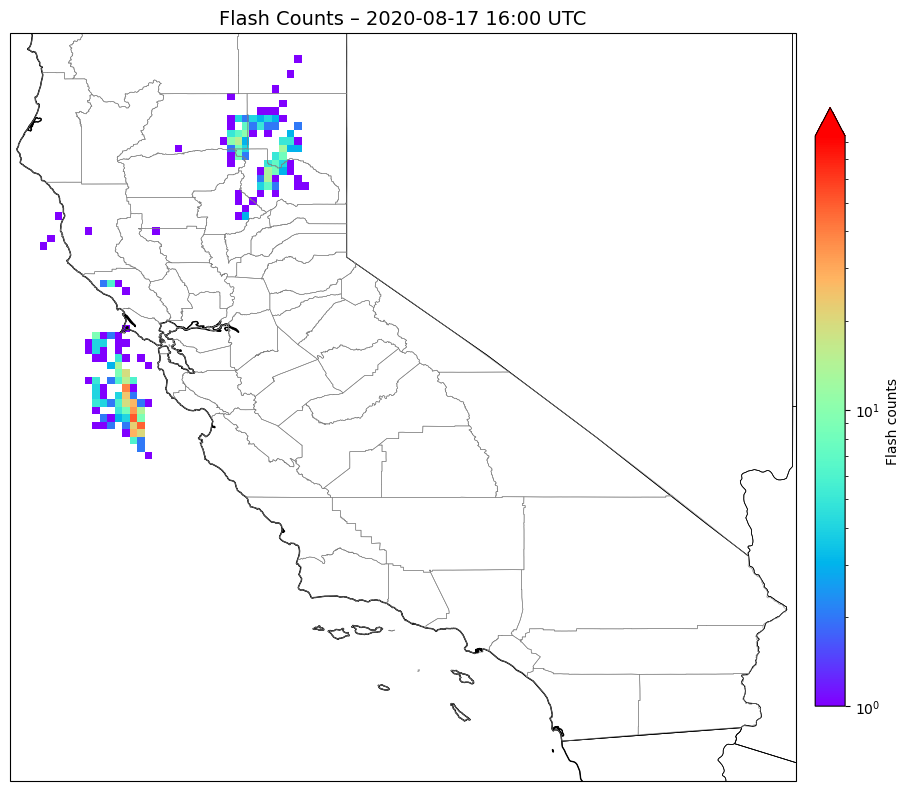

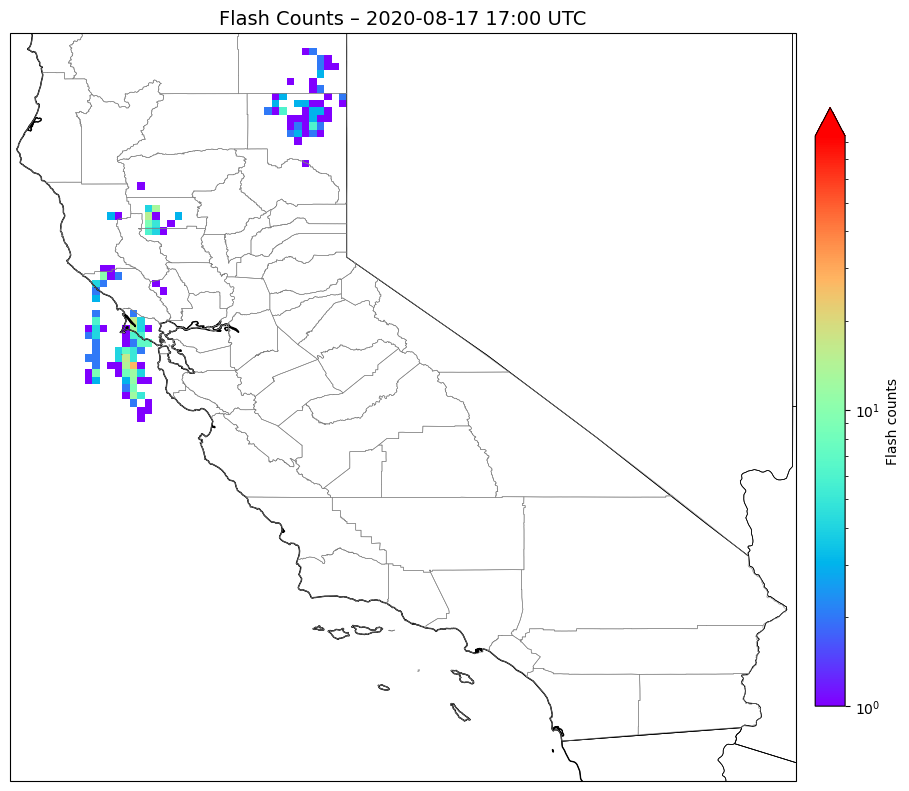

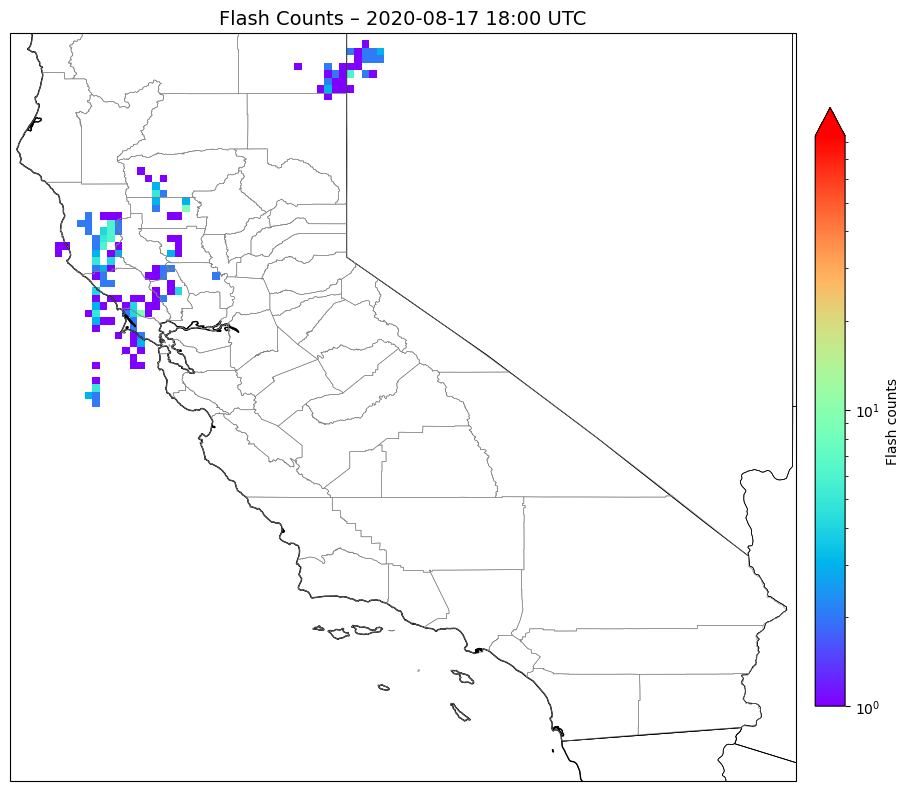

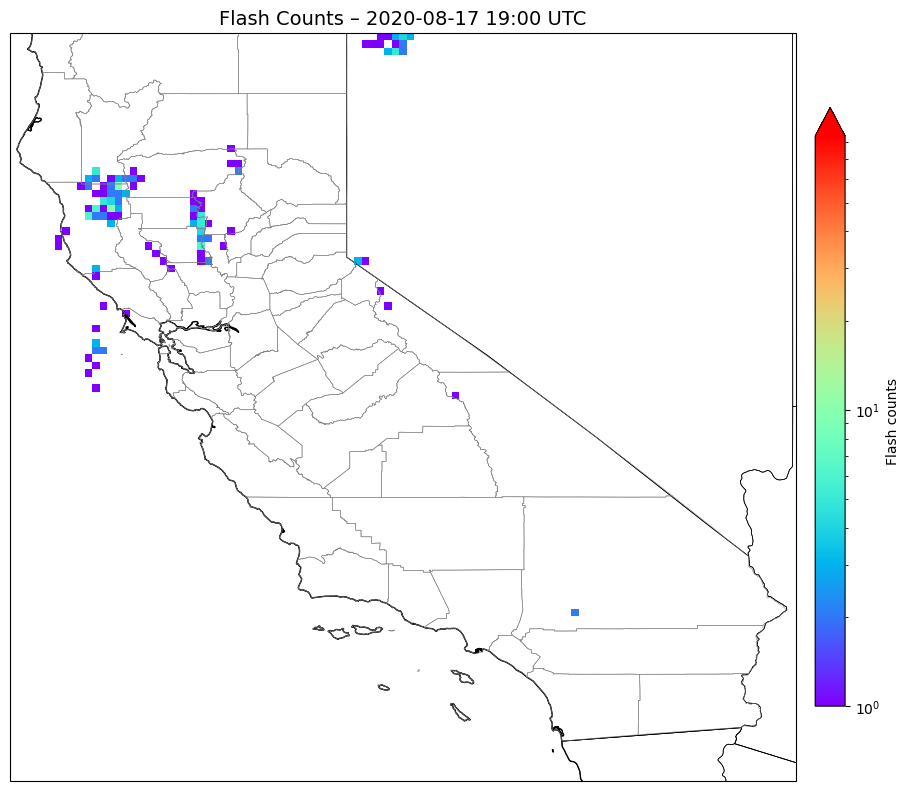

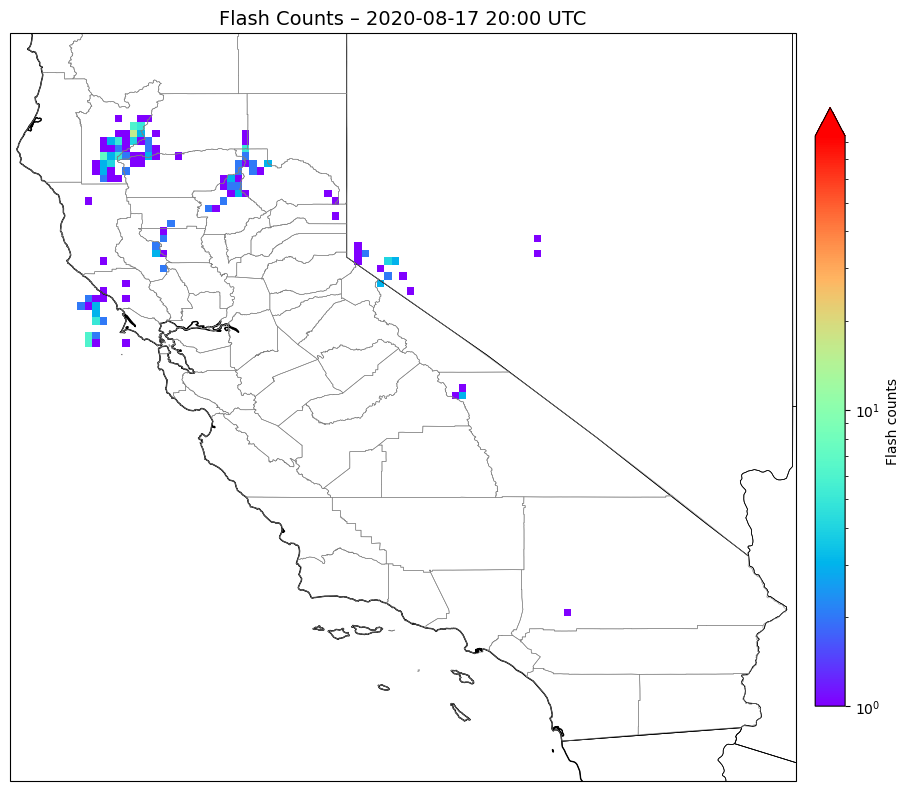

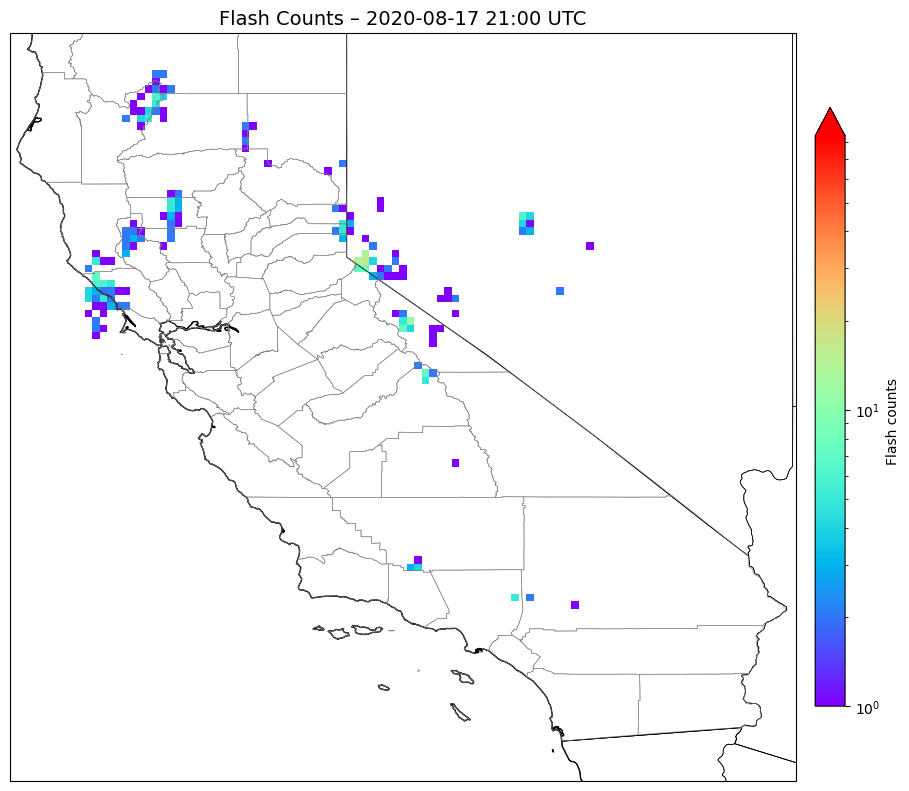

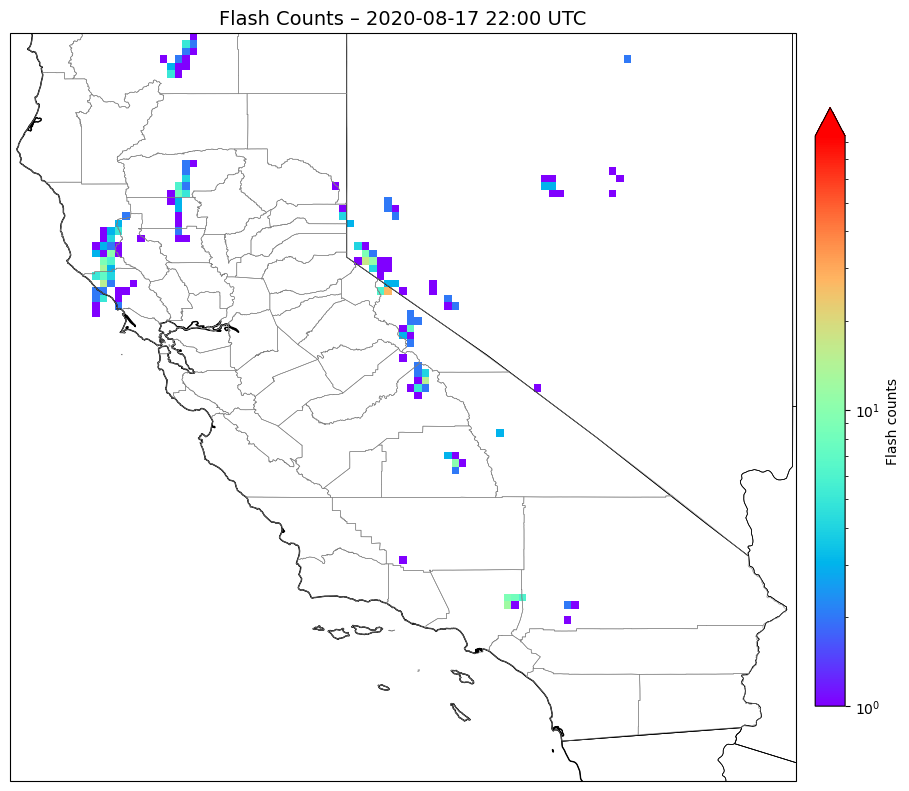

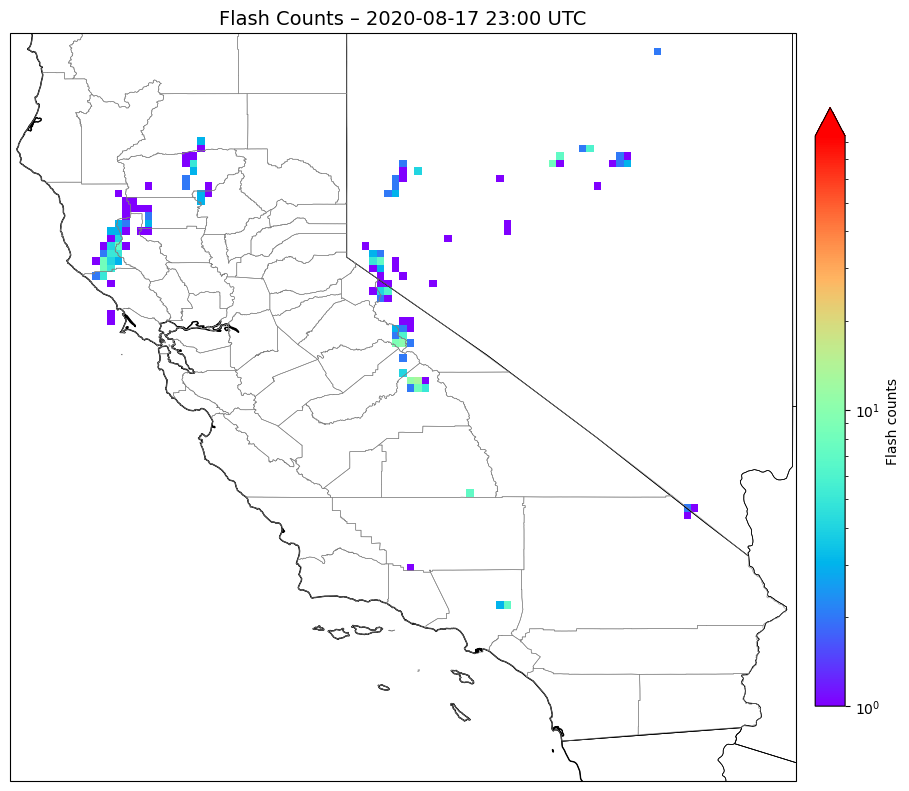

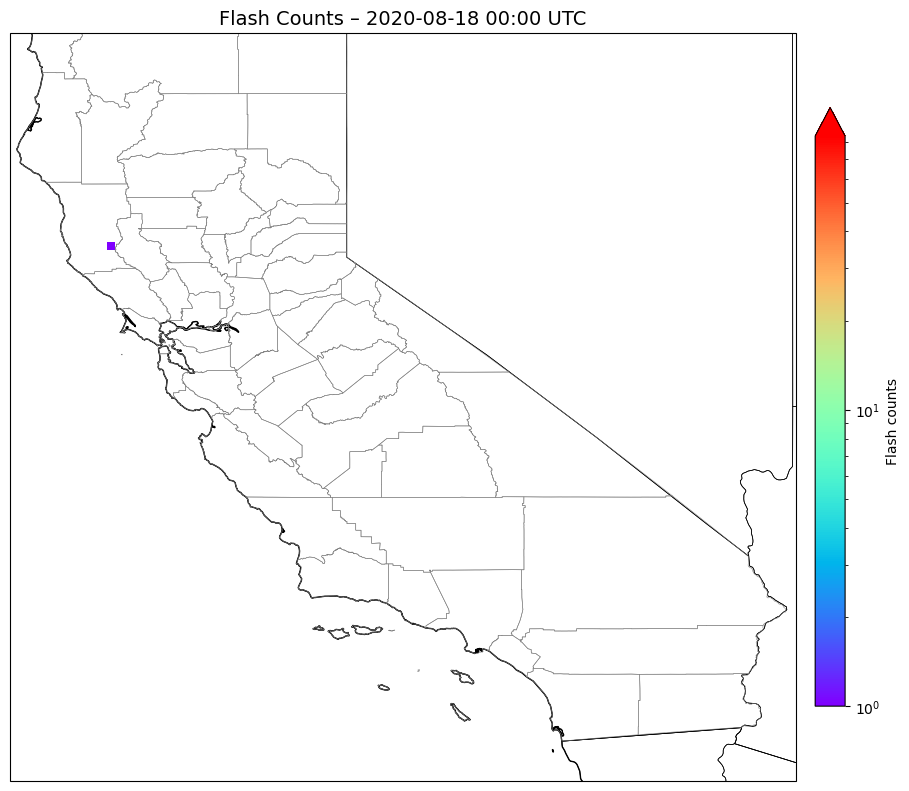

Done – hourly flash density maps saved to: D:\1Research\2025\NOAA_SatHack\figures\flash_hourly


In [2]:
import os
import glob
import re
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from netCDF4 import Dataset
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
from datetime import datetime, timedelta

# 0. DIRECTORIES and PARAMETERS
glm_dir     = r'D:\1Research\2025\NOAA_SatHack\data\glm_ca_subset'
county_shp  = r'D:\1Research\2025\NOAA_SatHack\cb_2018_us_county_500k\cb_2018_us_county_500k.shp'
output_dir  = r'D:\1Research\2025\NOAA_SatHack\figures\flash_hourly'
os.makedirs(output_dir, exist_ok=True)

lon_min, lon_max = -124.5, -114.0
lat_min, lat_max =   32.0,    42.0
res = 0.1

# Building bin edges 
lon_edges = np.arange(lon_min, lon_max + res, res)
lat_edges = np.arange(lat_min, lat_max + res, res)
nlat = len(lat_edges) - 1
nlon = len(lon_edges) - 1

# 1. ACCUMULATE FLASH COUNTS INTO HOURLY BINS
# regex to pull _cYYYYDDDHHMMSS from filename
pattern = re.compile(r'_c(\d{4})(\d{3})(\d{2})(\d{2})(\d{2})')

counts_hour = {}

for nc_path in glob.glob(os.path.join(glm_dir, '*.nc')):
    fname = os.path.basename(nc_path)
    m = pattern.search(fname)
    if not m:
        continue

    year, doy, hh, mm, ss = map(int, m.groups())
    # convert to datetime
    dt = datetime(year, 1, 1) + timedelta(days=doy-1,
                                         hours=hh,
                                         minutes=mm,
                                         seconds=ss)
    hour_key = dt.strftime('%Y%m%d%H')

    # lazy initialize grid
    if hour_key not in counts_hour:
        counts_hour[hour_key] = np.zeros((nlat, nlon), dtype=np.float64)

    with Dataset(nc_path, 'r') as ds:
        lat = ds.variables['flash_lat'][:]
        lon = ds.variables['flash_lon'][:]

    # mask flashes outside CA box
    mask = (
        (lon >= lon_min) & (lon < lon_max) &
        (lat >= lat_min) & (lat < lat_max)
    )
    lon_f = lon[mask]
    lat_f = lat[mask]
    if lon_f.size == 0:
        continue

    ix = np.digitize(lon_f, lon_edges) - 1
    iy = np.digitize(lat_f, lat_edges) - 1

    grid = counts_hour[hour_key]
    for x, y in zip(ix, iy):
        if 0 <= x < nlon and 0 <= y < nlat:
            grid[y, x] += 1

# 2. PRE-COMPUTE GLOBAL vmax FOR UNIFORM COLORBAR
all_max = []
for grid in counts_hour.values():
    masked = np.ma.masked_less(grid, 1.0)
    if masked.count() > 0:
        all_max.append(masked.max())
global_vmax = float(max(all_max)) if all_max else 2.0
print(f"Fixed colorbar range: vmin=1, vmax={global_vmax:.1f}")

# 3. LOAD CALIFORNIA COUNTY OUTLINES
counties = gpd.read_file(county_shp)
ca_counties = counties[counties.STATEFP == '06']

# 4. PLOT and SAVE HOURLY FLASH DENSITY MAPS
# prepare a colormap that shows <1 as white
cmap = plt.get_cmap('rainbow').copy()
cmap.set_under('white')  # values below vmin → white

for hour_key in sorted(counts_hour):
    grid = counts_hour[hour_key]
    masked = np.ma.masked_less(grid, 1.0)
    if masked.count() == 0:
        print(f"{hour_key}: no flashes ≥1 → skipping")
        continue

    dt = datetime.strptime(hour_key, '%Y%m%d%H')
    title = dt.strftime('Flash Counts – %Y-%m-%d %H:00 UTC')

    fig, ax = plt.subplots(
        figsize=(10, 8),
        subplot_kw=dict(projection=ccrs.PlateCarree())
    )
    ax.set_extent([lon_min, lon_max, lat_min, lat_max],
                  crs=ccrs.PlateCarree())

    mesh = ax.pcolormesh(
        lon_edges, lat_edges,
        masked,
        cmap=cmap,
        norm=LogNorm(vmin=1, vmax=global_vmax),
        transform=ccrs.PlateCarree(),
        shading='auto'
    )

    ax.coastlines(resolution='10m', linewidth=1)
    ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=0.5)
    ax.add_feature(cfeature.BORDERS.with_scale('10m'), linewidth=0.5)
    ax.add_geometries(
        ca_counties.geometry,
        crs=ccrs.PlateCarree(),
        edgecolor='gray',
        facecolor='none',
        linewidth=0.4
    )

    cbar = plt.colorbar(
        mesh, ax=ax,
        orientation='vertical', pad=0.02, shrink=0.8,
        extend='max'
    )
    cbar.set_label('Flash counts')

    ax.set_title(title, fontsize=14)
    plt.tight_layout()

    out_png = os.path.join(output_dir, f'flash_{hour_key}.png')
    plt.savefig(out_png, dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig)

print("Done – hourly flash density maps saved to:", output_dir)
